In [1]:
from IPython.display import display, HTML

In [2]:
display(HTML("""
<style>
 .messagebox{
     border-radius: 2px;
     padding: 1.25em 1.5em;
     border: 1px solid;
 }
.messagelightgreen{
     border-color: hsl(164deg 95% 38%);
     color: rgb(5 139 102);
     background-color: rgb(236 255 250);
 }
 .messagelightgreen b{
     color:rgb(139 77 5);
 }
 .messagebrown{
     border-color: hsl(35deg 96% 62%);
    color: rgb(143 84 4);
    background-color: rgb(255 245 234);
 }
 .messagebrown b{
     color: rgb(5 139 102);
 }
</style>"""))

In [ ]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc, plot_ks_statistic, plot_calibration_curve, plot_lift_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
import warnings
import itertools
import glob
import os
from sklearn.metrics import roc_auc_score

In [26]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
plt.rcParams["patch.force_edgecolor"] = True

In [27]:
mirai_df_list = []
for file in glob.glob("Danmini/mirai/*.csv"):
    tmp_df = pd.read_csv(file)
    tmp_df["target"] = "mirai-" + os.path.splitext(os.path.basename(file))[0]
    mirai_df_list.append(tmp_df)


In [28]:
gafgyt_df_list = []
for file in glob.glob("Danmini/gafgyt/*.csv"):
    tmp_df = pd.read_csv(file)
    tmp_df["target"] = "gafgyt-" + os.path.splitext(os.path.basename(file))[0]
    gafgyt_df_list.append(tmp_df)

In [29]:
benign_df = pd.read_csv("Danmini/benign_traffic.csv")
benign_df["target"] = "benign"
gafgyt_df_list.append(benign_df)

In [30]:
df_list = mirai_df_list + gafgyt_df_list

In [31]:
df = pd.concat(df_list)

In [32]:
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,target
0,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
1,1.996585,566.0,5.820766e-11,1.997950,566.0,5.820766e-11,1.999316,566.0,0.000000e+00,1.999932,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
2,2.958989,566.0,0.000000e+00,2.975291,566.0,5.820766e-11,2.991729,566.0,5.820766e-11,2.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
3,3.958979,566.0,0.000000e+00,3.975285,566.0,0.000000e+00,3.991727,566.0,1.164153e-10,3.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
4,4.914189,566.0,1.164153e-10,4.948239,566.0,5.820766e-11,4.982654,566.0,5.820766e-11,4.998261,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018298 entries, 0 to 49547
Columns: 116 entries, MI_dir_L5_weight to target
dtypes: float64(115), object(1)
memory usage: 909.0+ MB


In [34]:
def display_bar_chart(data, xvalues, yvalues, graph_title, xtitle, ytitle, legend_position_dict=None):
    fig = px.bar(data, x=xvalues, y=yvalues, color=xvalues, text_auto=True, color_continuous_scale='algae')
    fig.update_layout(title=graph_title, xaxis_title=xtitle, yaxis_title=ytitle)
    if legend_position_dict:
        fig.update_layout(legend=legend_position_dict)
    fig.show()

In [35]:
def display_pie_chart(data, xvalues, yvalues, graph_title, xtitle, ytitle, legend_position_dict=None):
    fig = px.pie(data, names=xvalues, values=yvalues, color=xvalues)
    fig.update_layout(title=graph_title, xaxis_title=xtitle, yaxis_title=ytitle)
    if legend_position_dict:
        fig.update_layout(legend=legend_position_dict)
    fig.show()

In [37]:
target_counts = df["target"].value_counts()
display_bar_chart(target_counts, target_counts.index, target_counts.values, "Target wise count", "IoT BoT Name", "No of Samples")

In [38]:
df.drop_duplicates(inplace=True)
factor = 10

In [39]:
def hyper_tune(number: float, value = factor) -> float:
    return number + value

In [40]:
binary_opt1_df = df.copy()
binary_opt1_df["target"].replace(regex=r'^mirai-[a-z]*', value='IoT-Bot-Attack', inplace=True)
binary_opt1_df["target"].replace(regex=r'^gafgyt-[a-z]*', value='IoT-Bot-Attack', inplace=True)
binary_target_counts = binary_opt1_df["target"].value_counts()
display_bar_chart(binary_target_counts, binary_target_counts.index, binary_target_counts.values, 
                  "Binary Classification: Target wise count", "Traffic Information", "No of Samples")


0 0 15


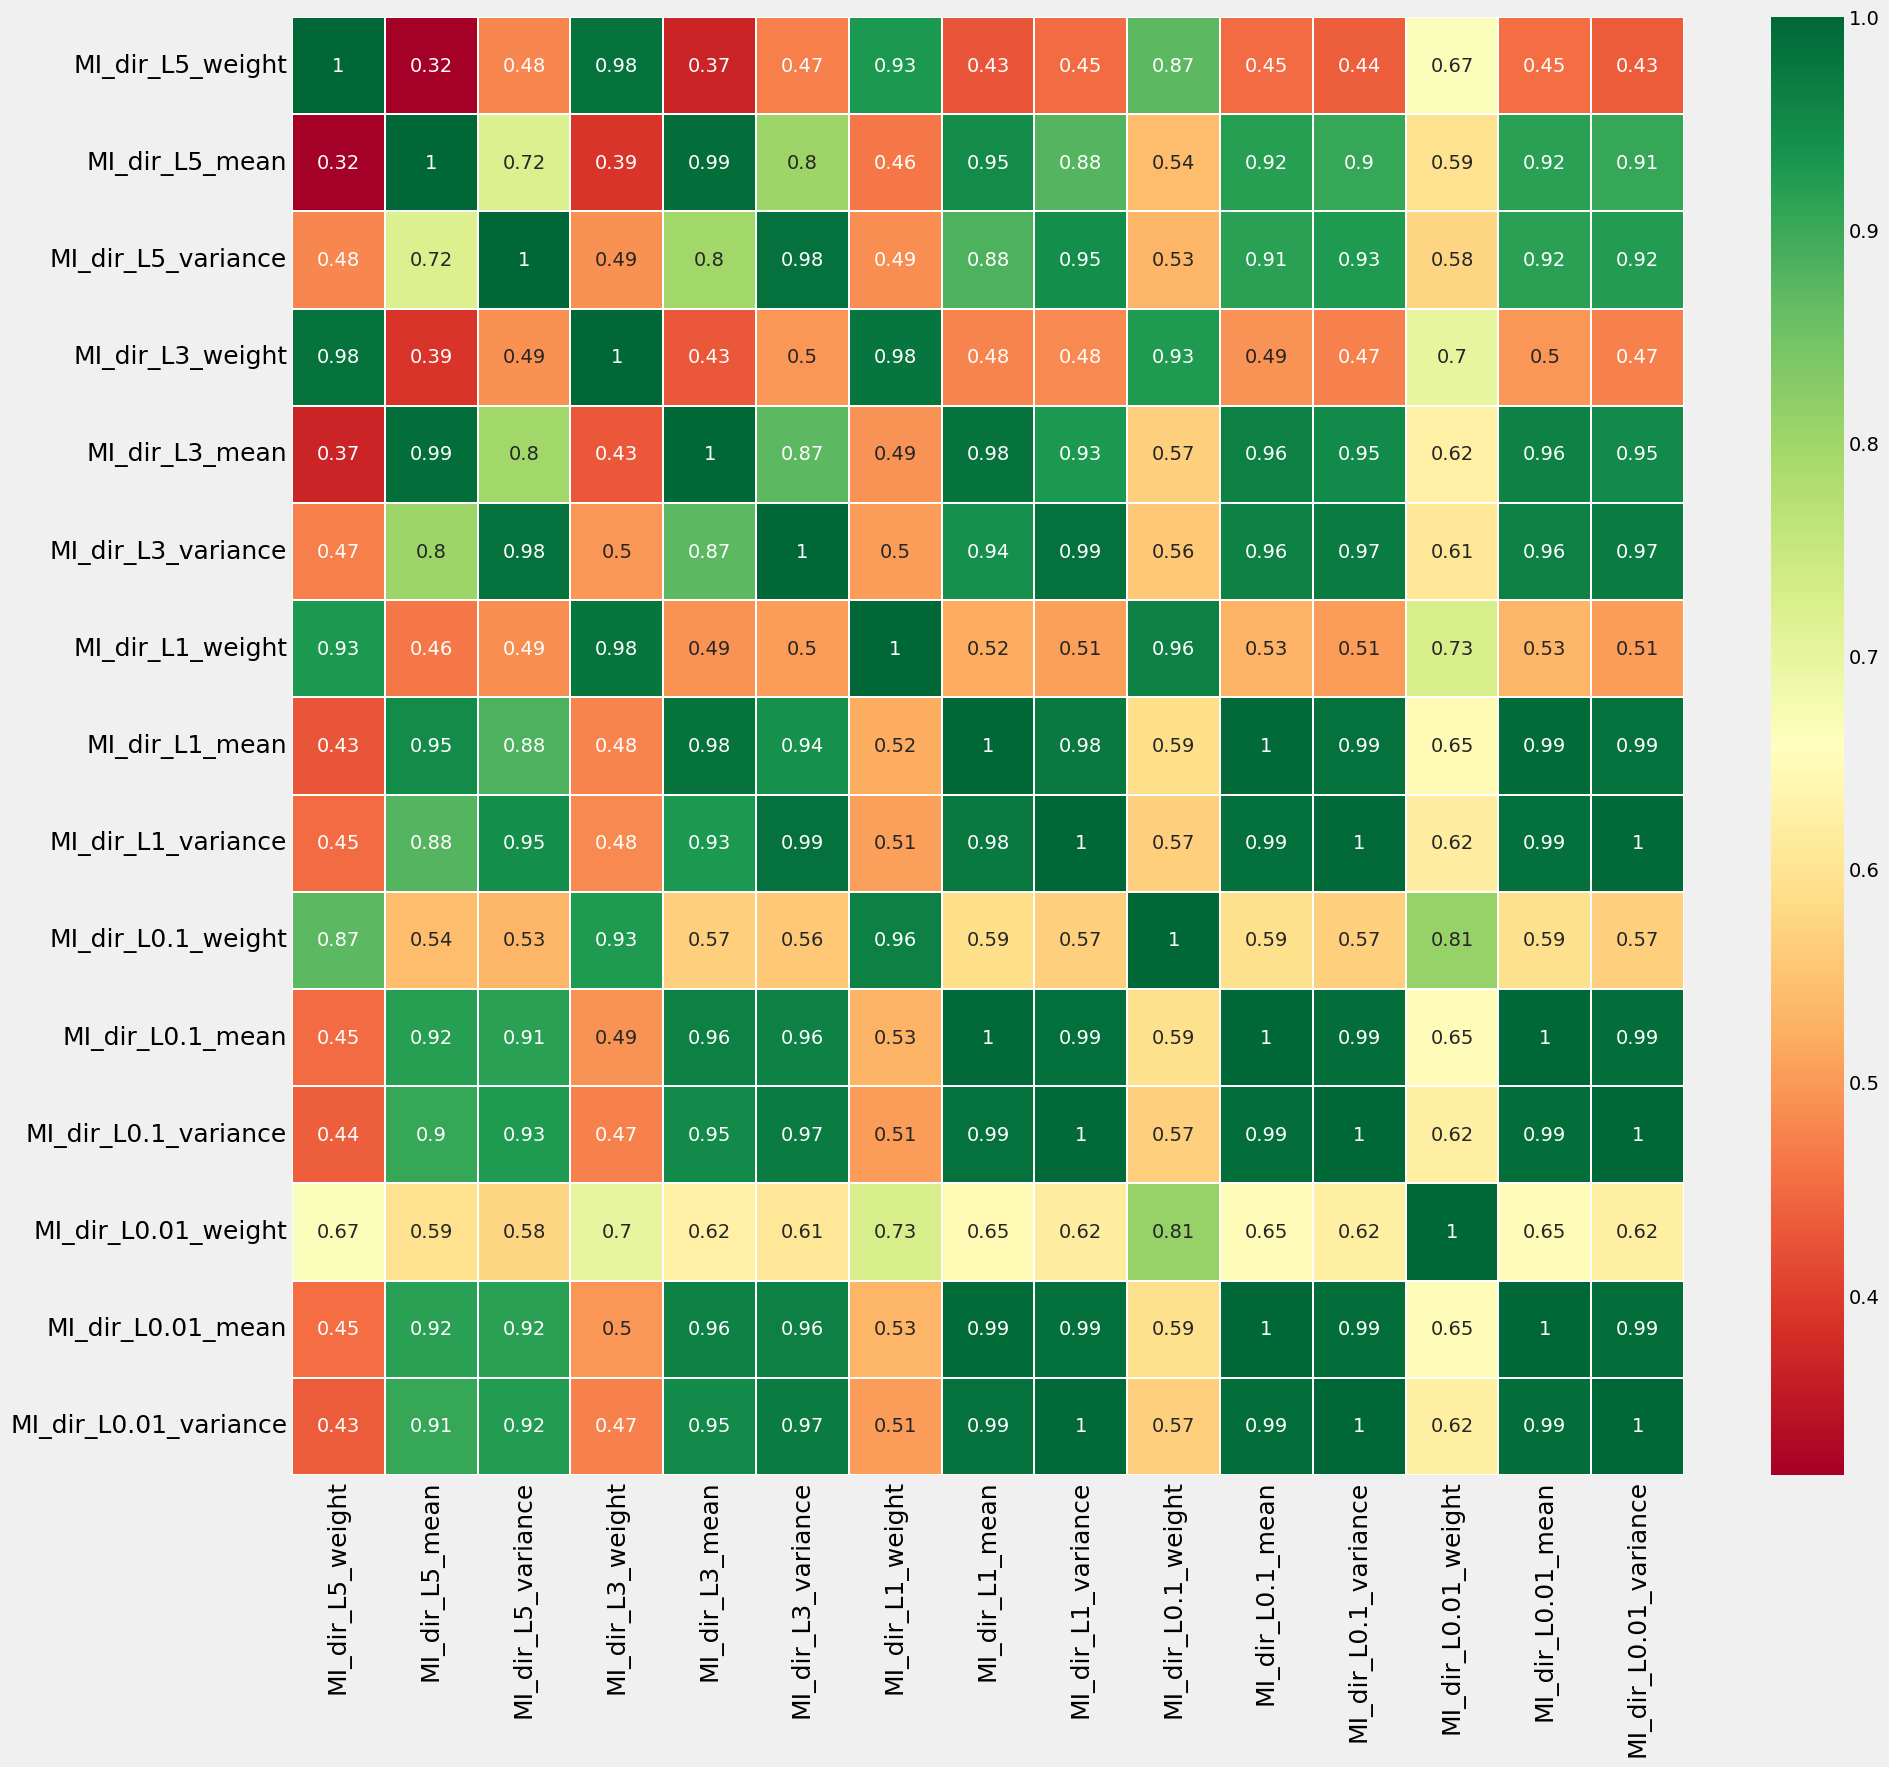

1 15 30


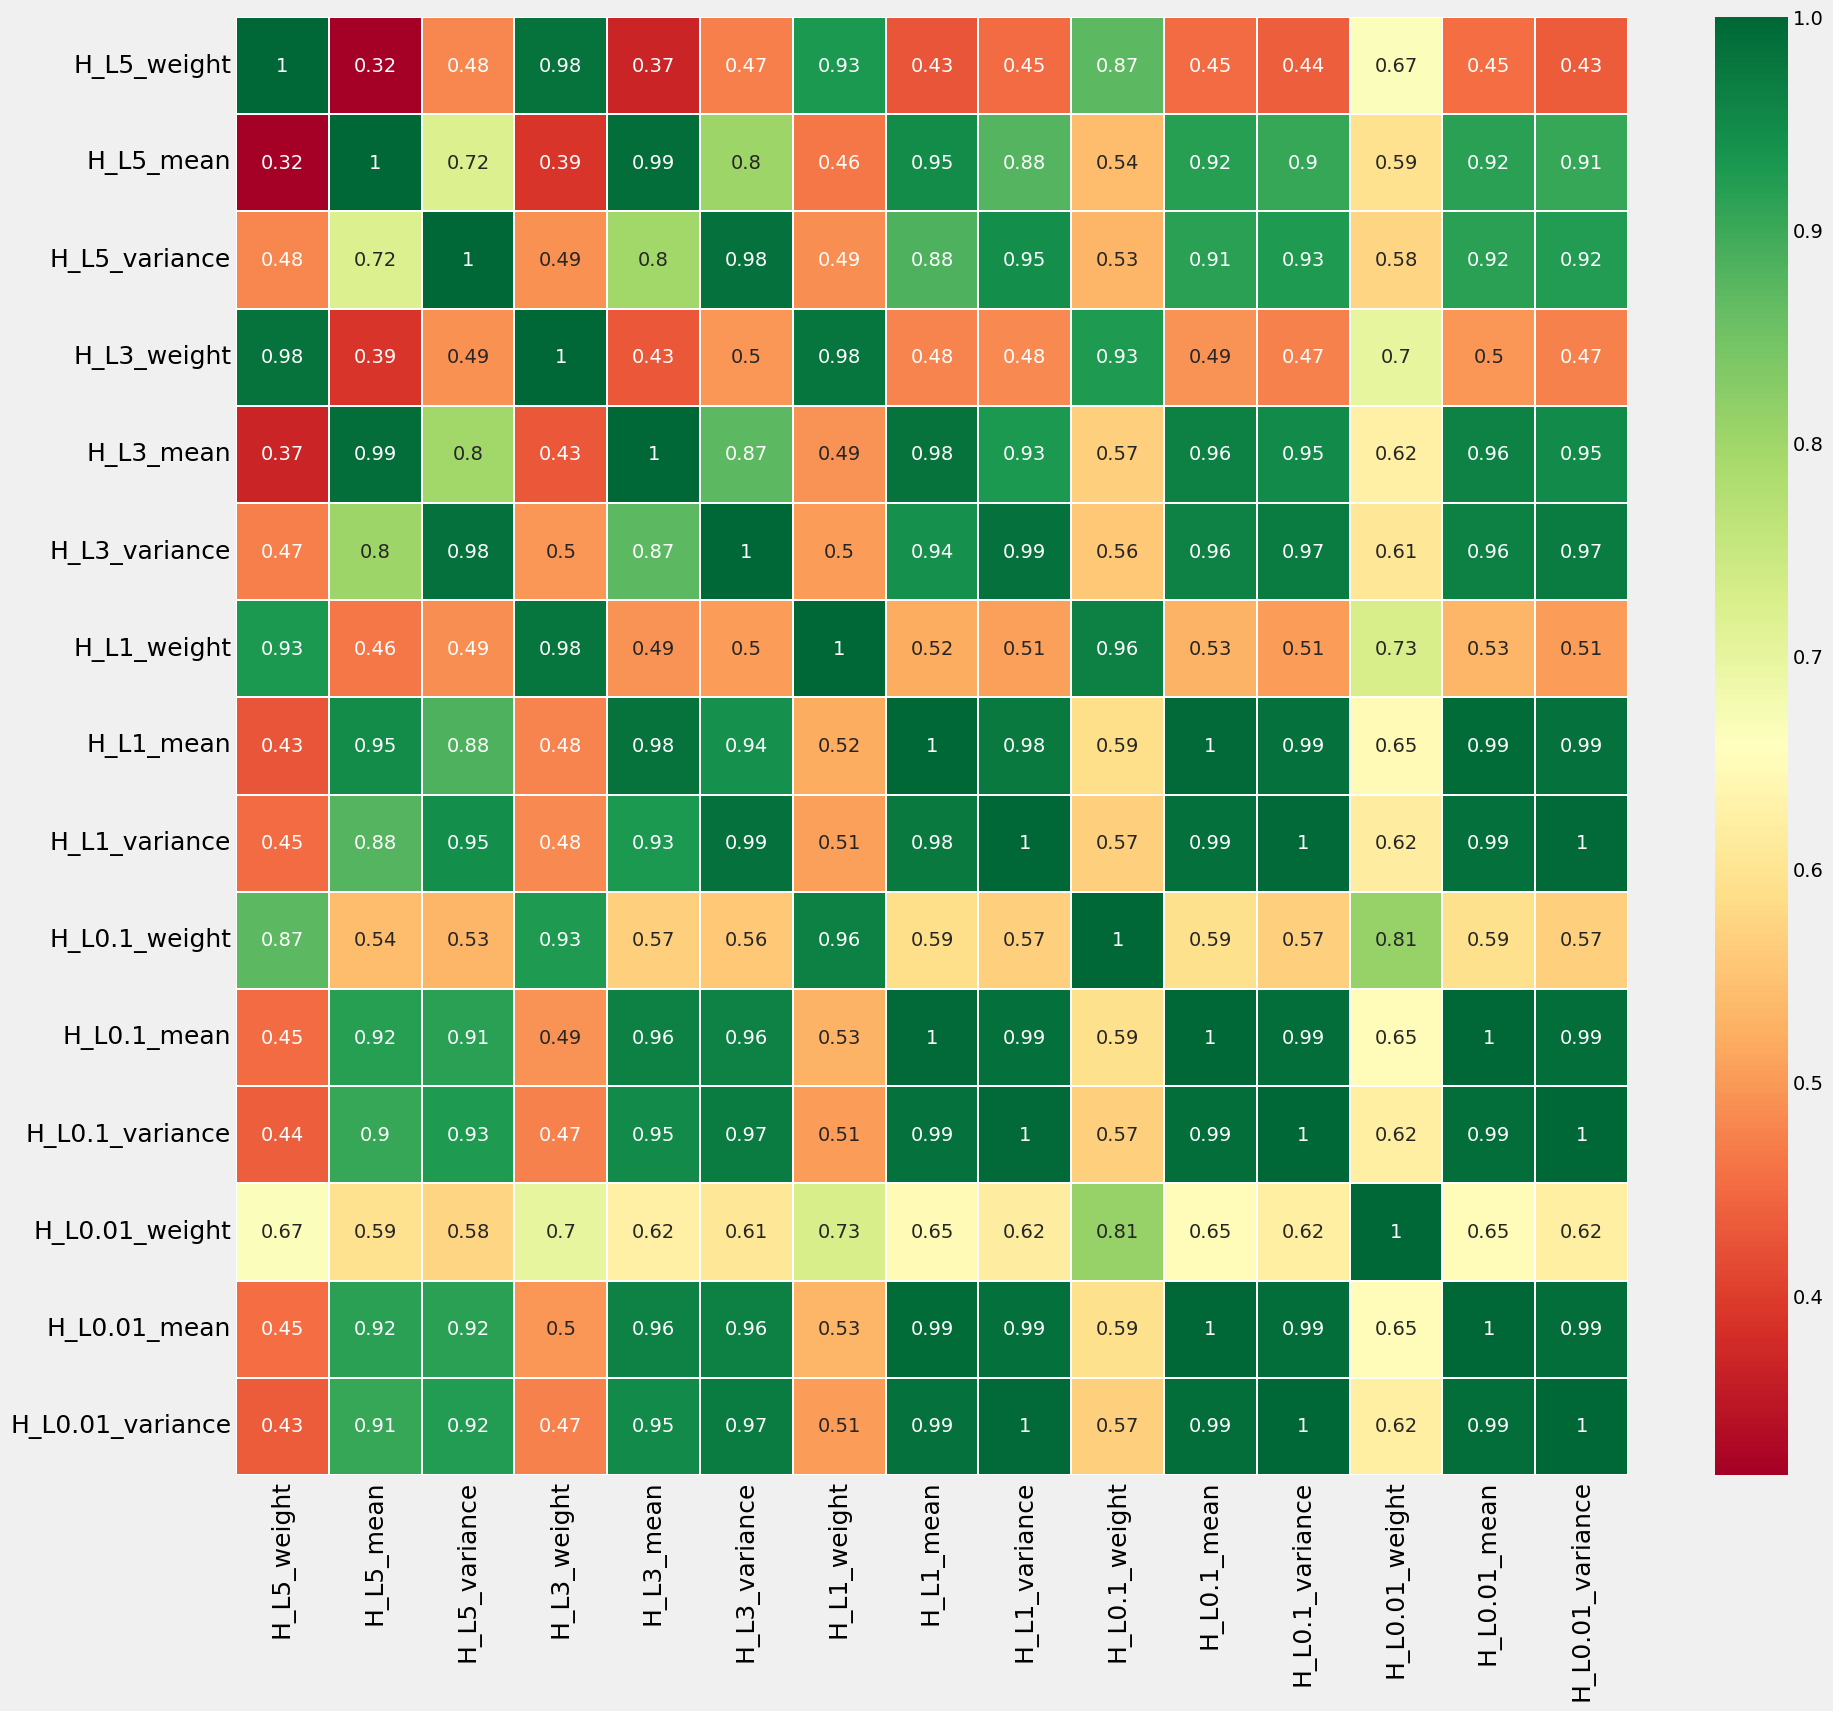

2 30 45


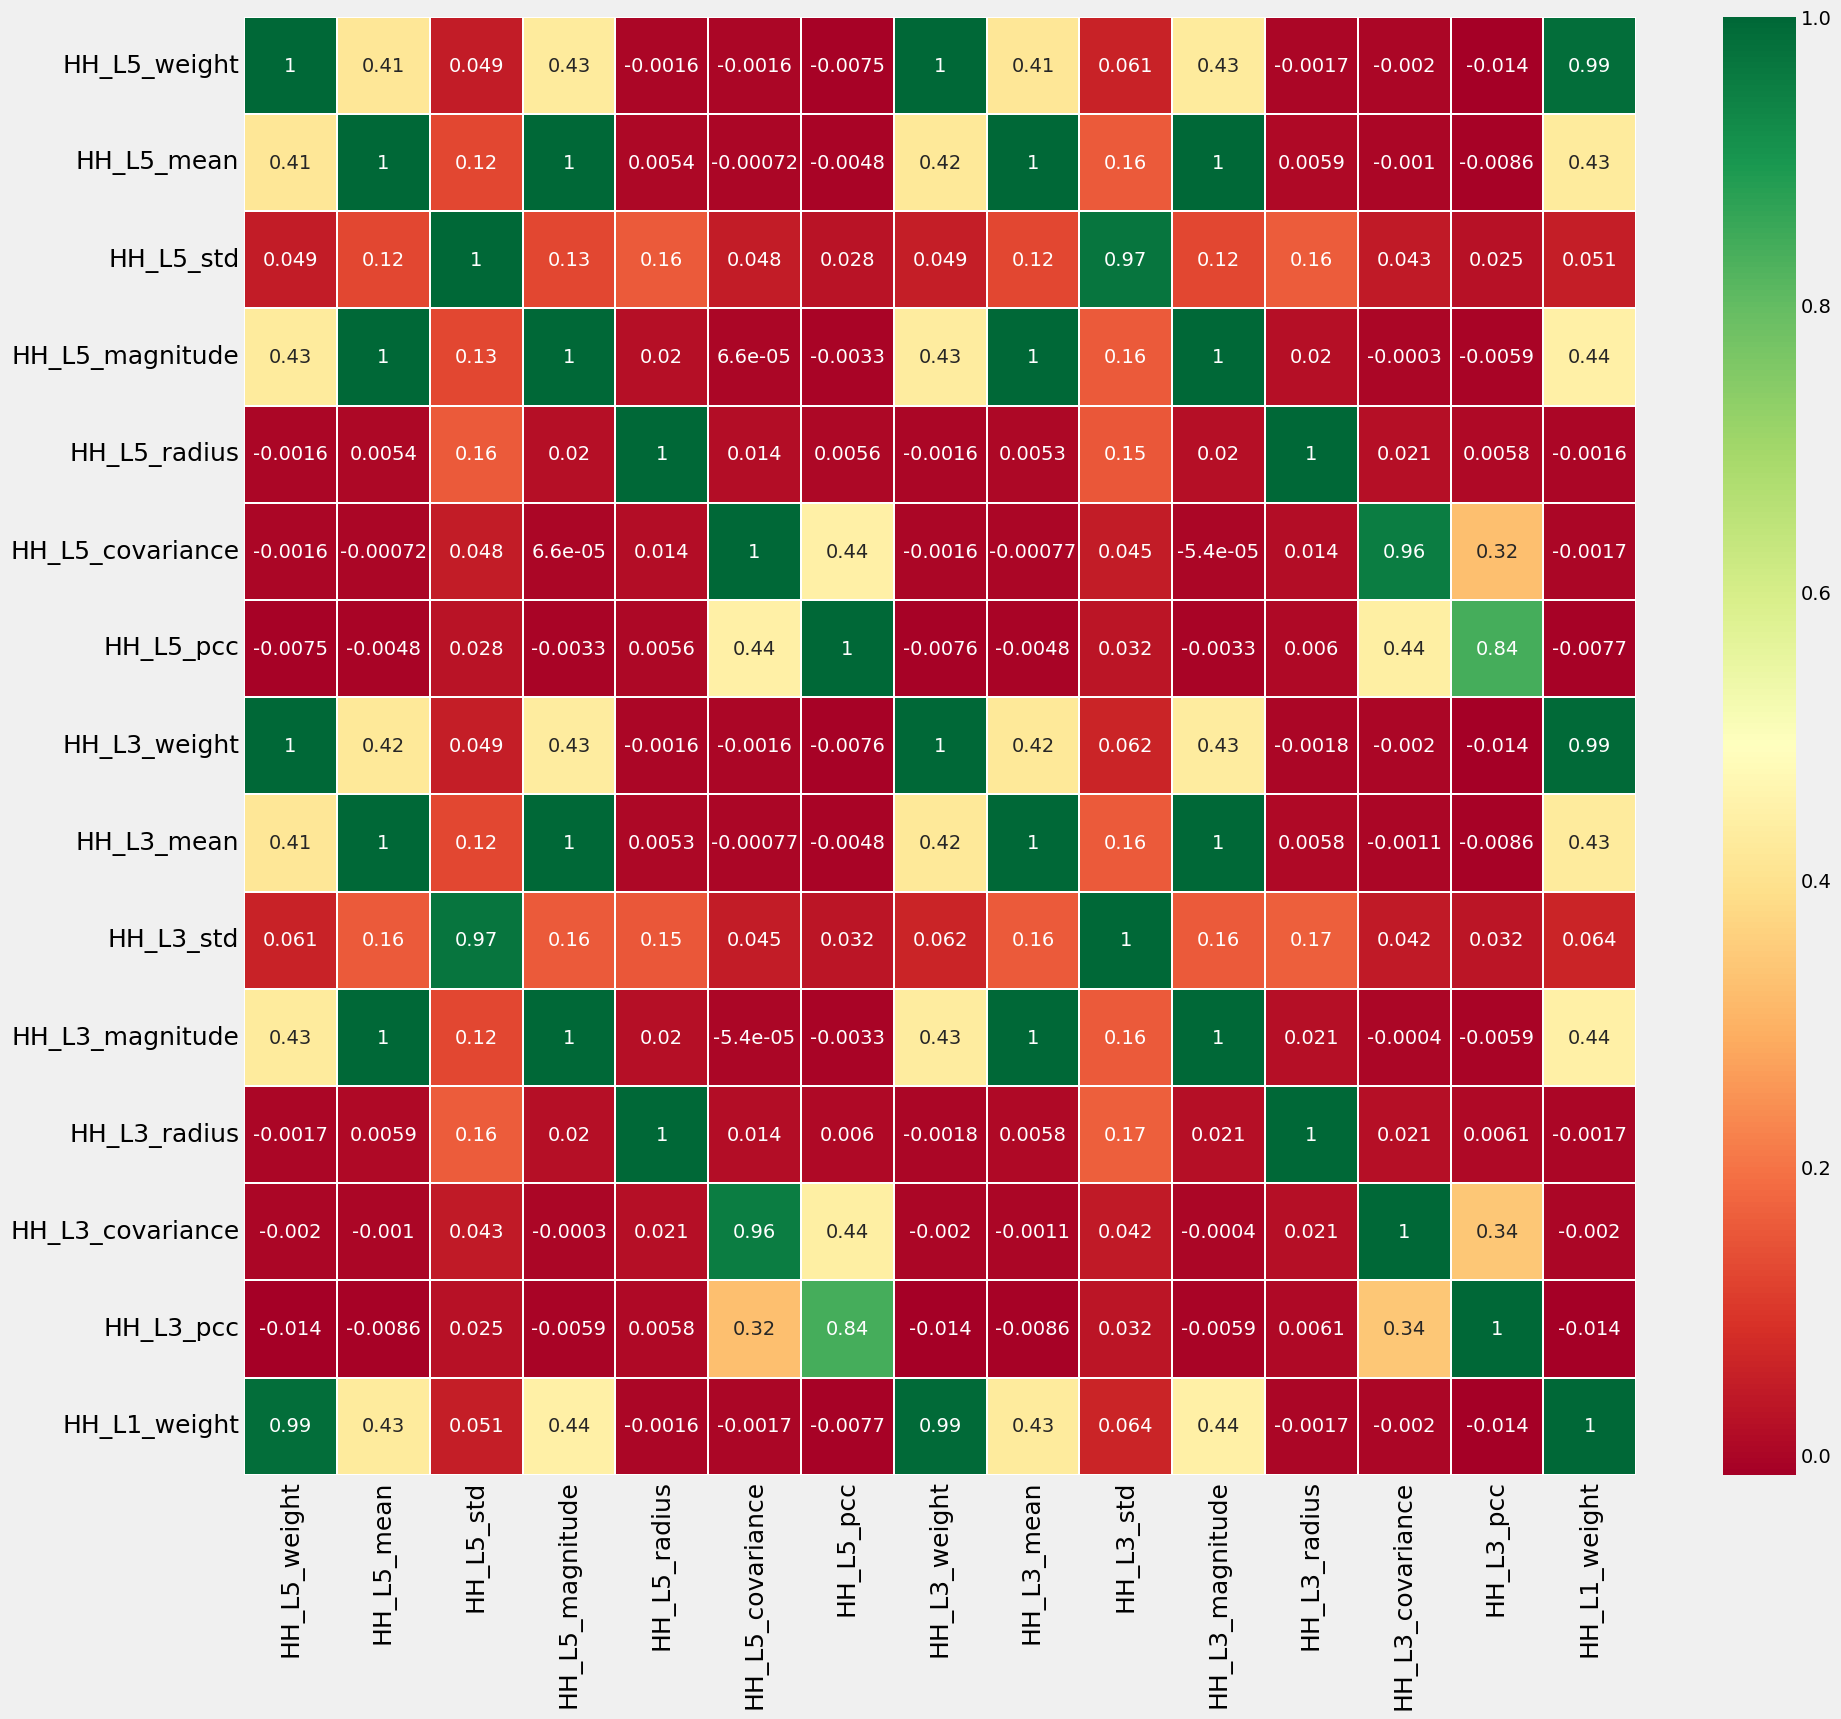

3 45 60


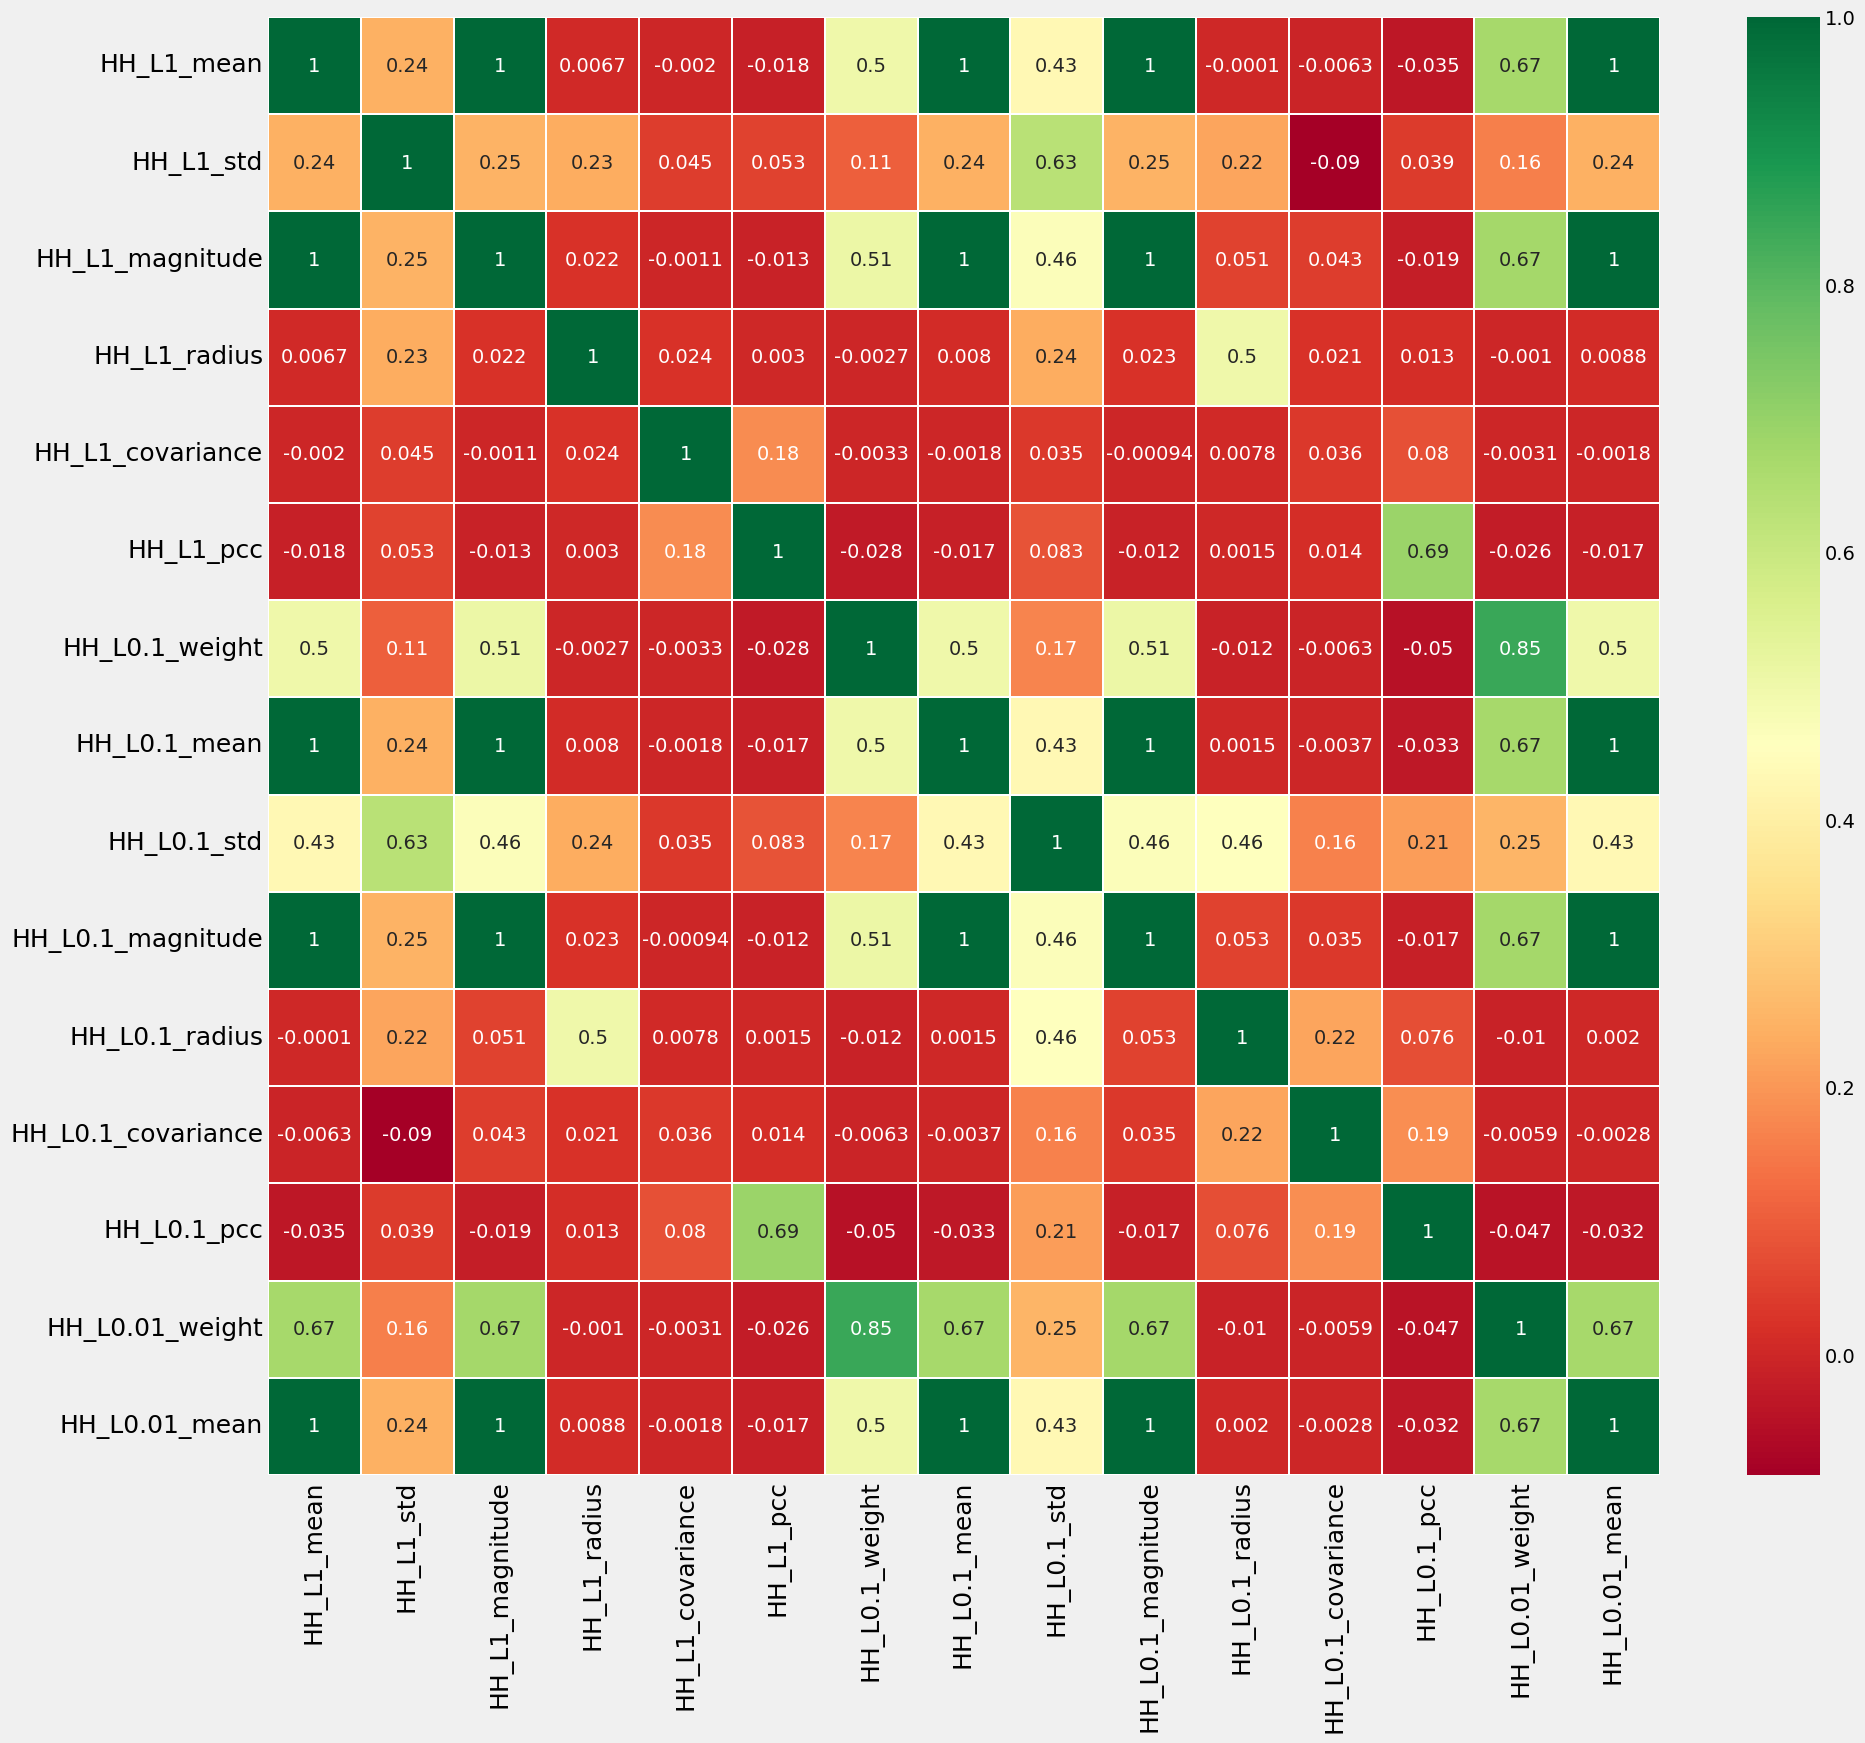

4 60 75


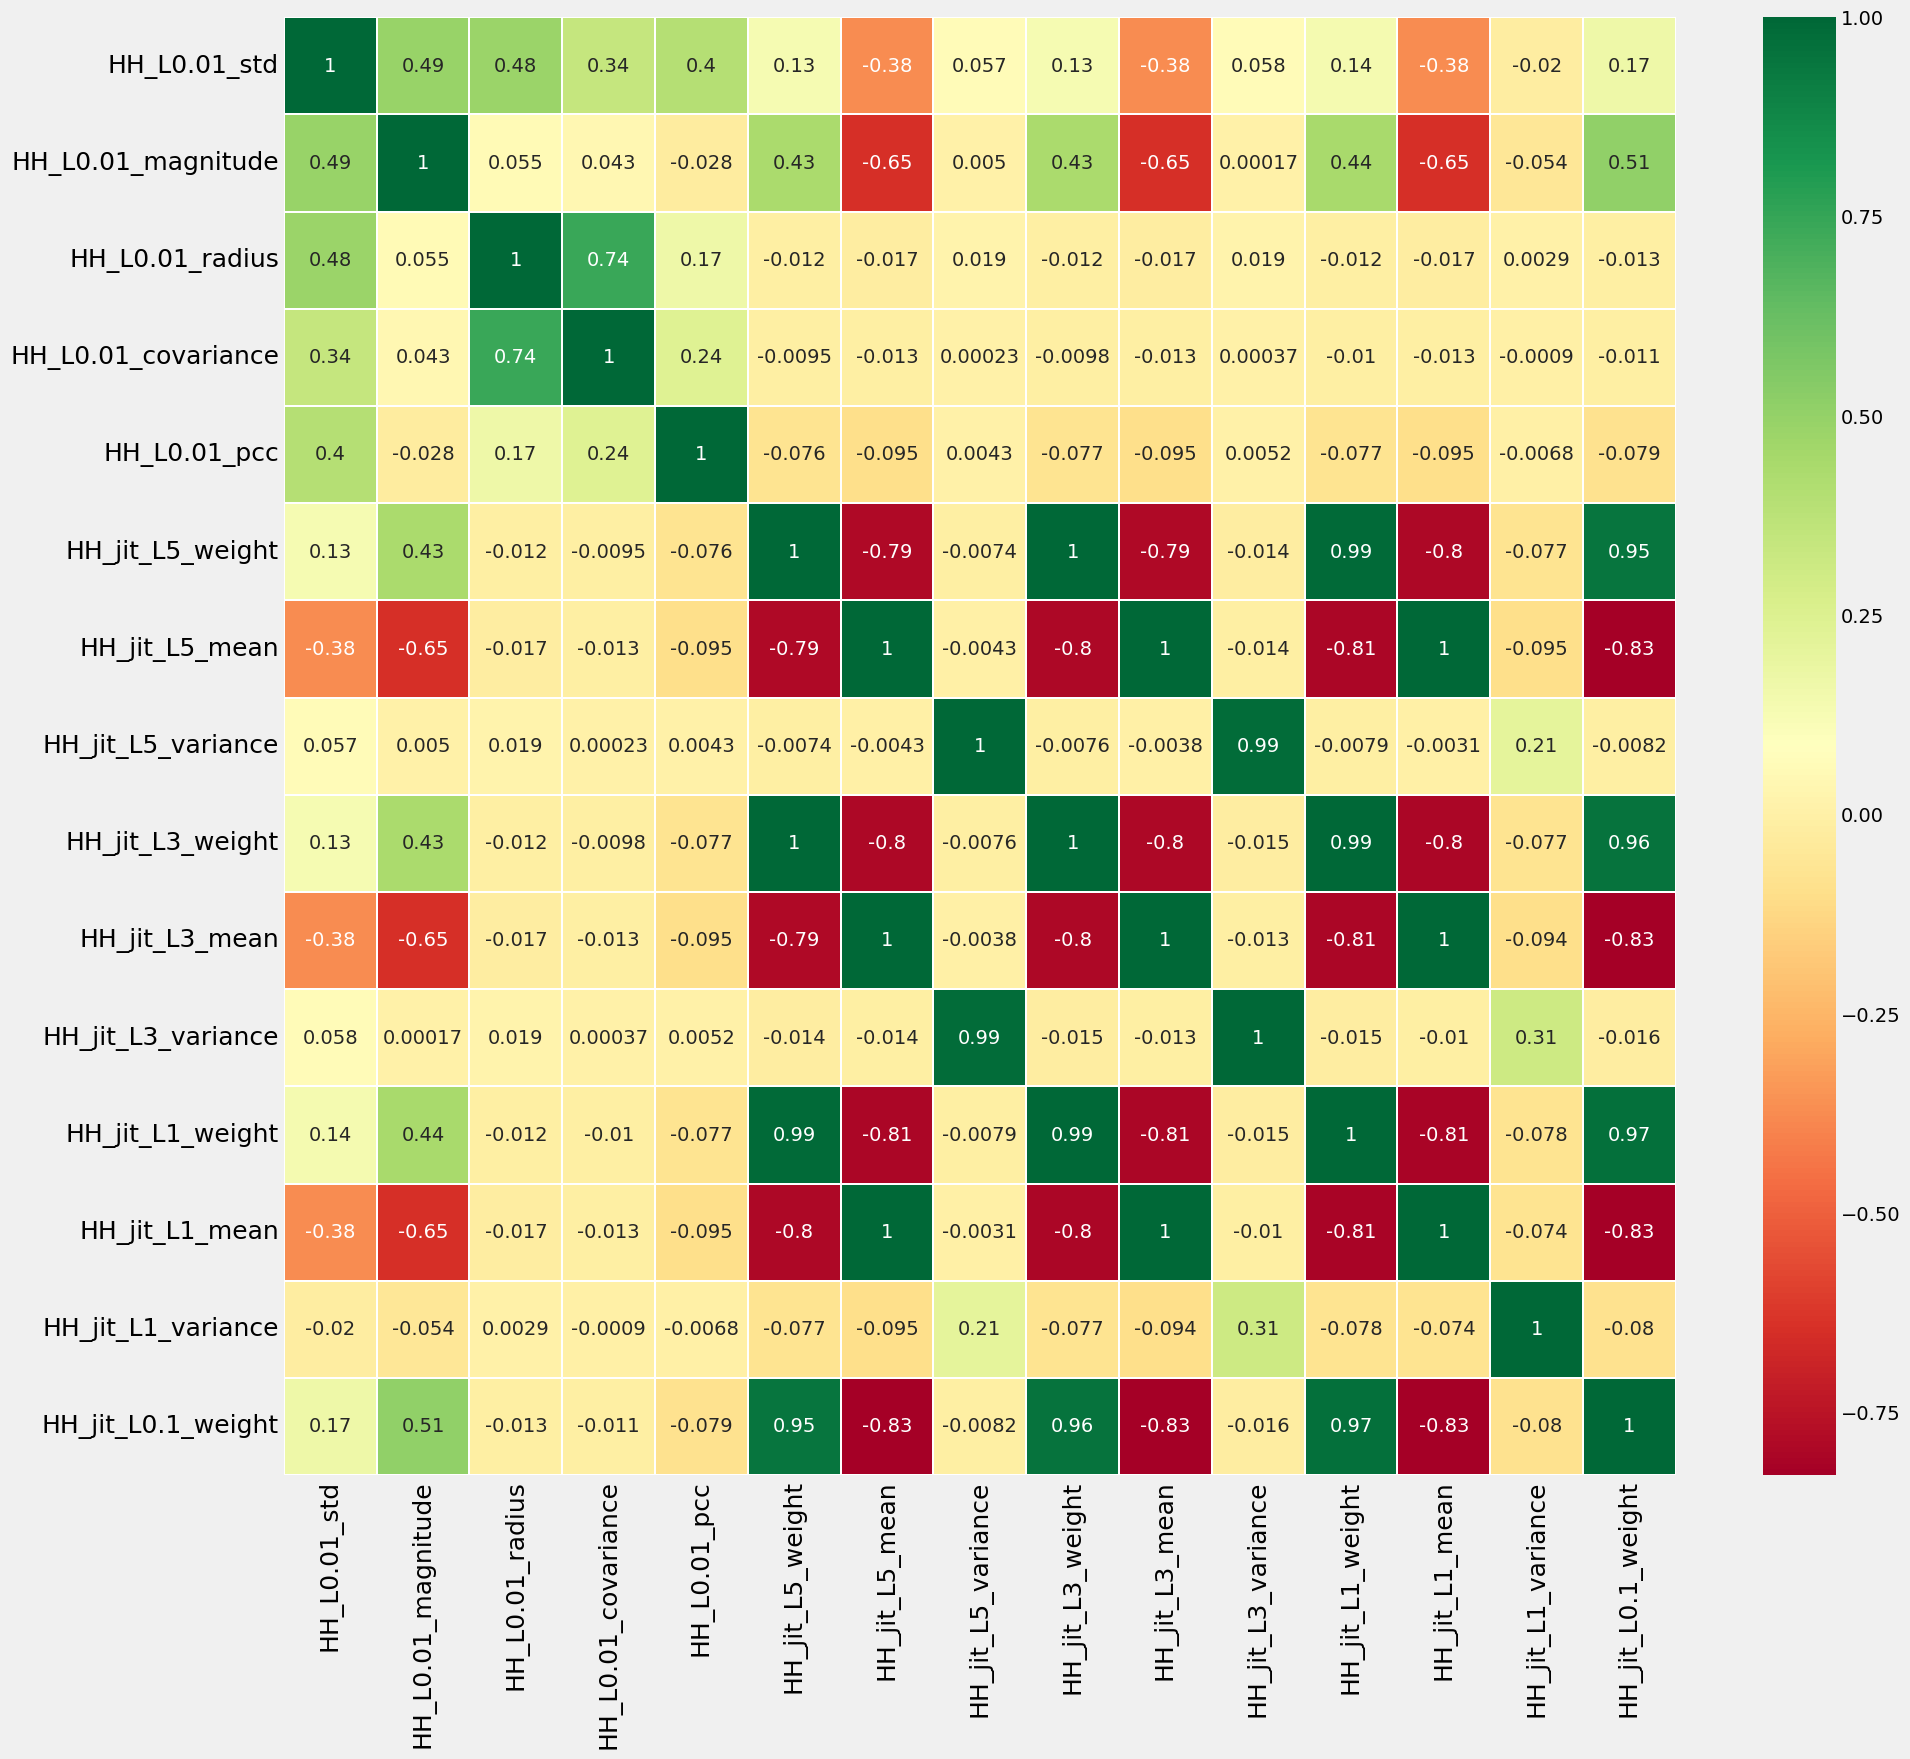

5 75 90


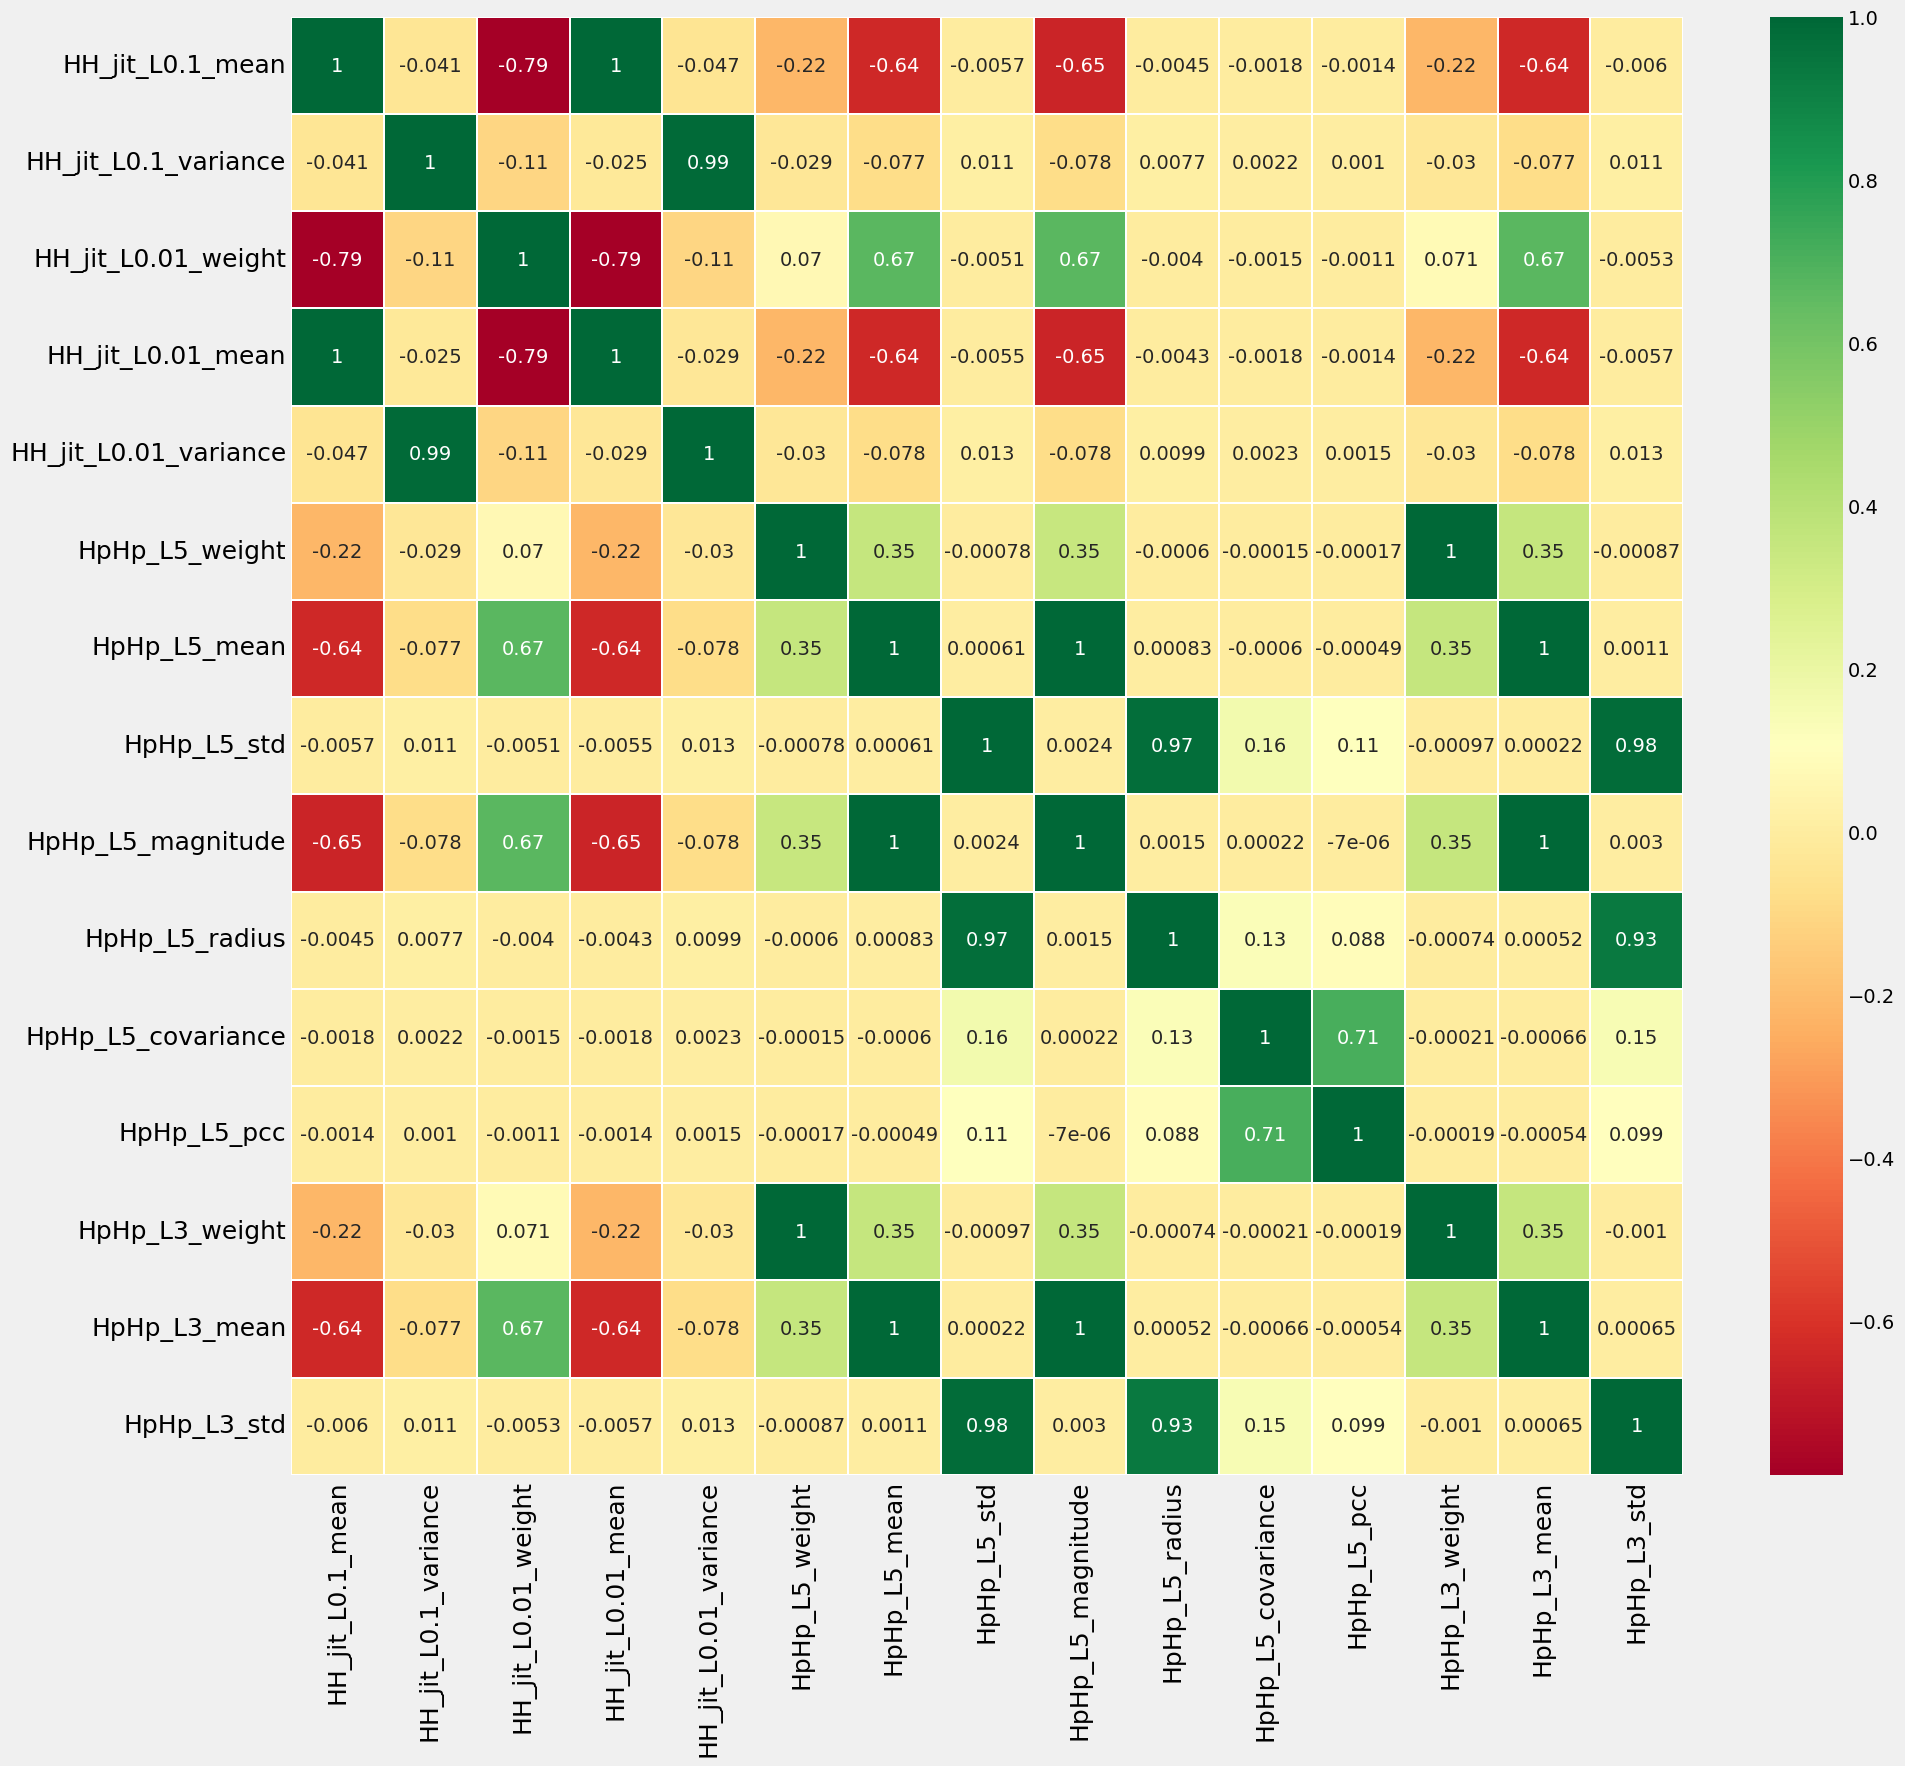

6 90 105


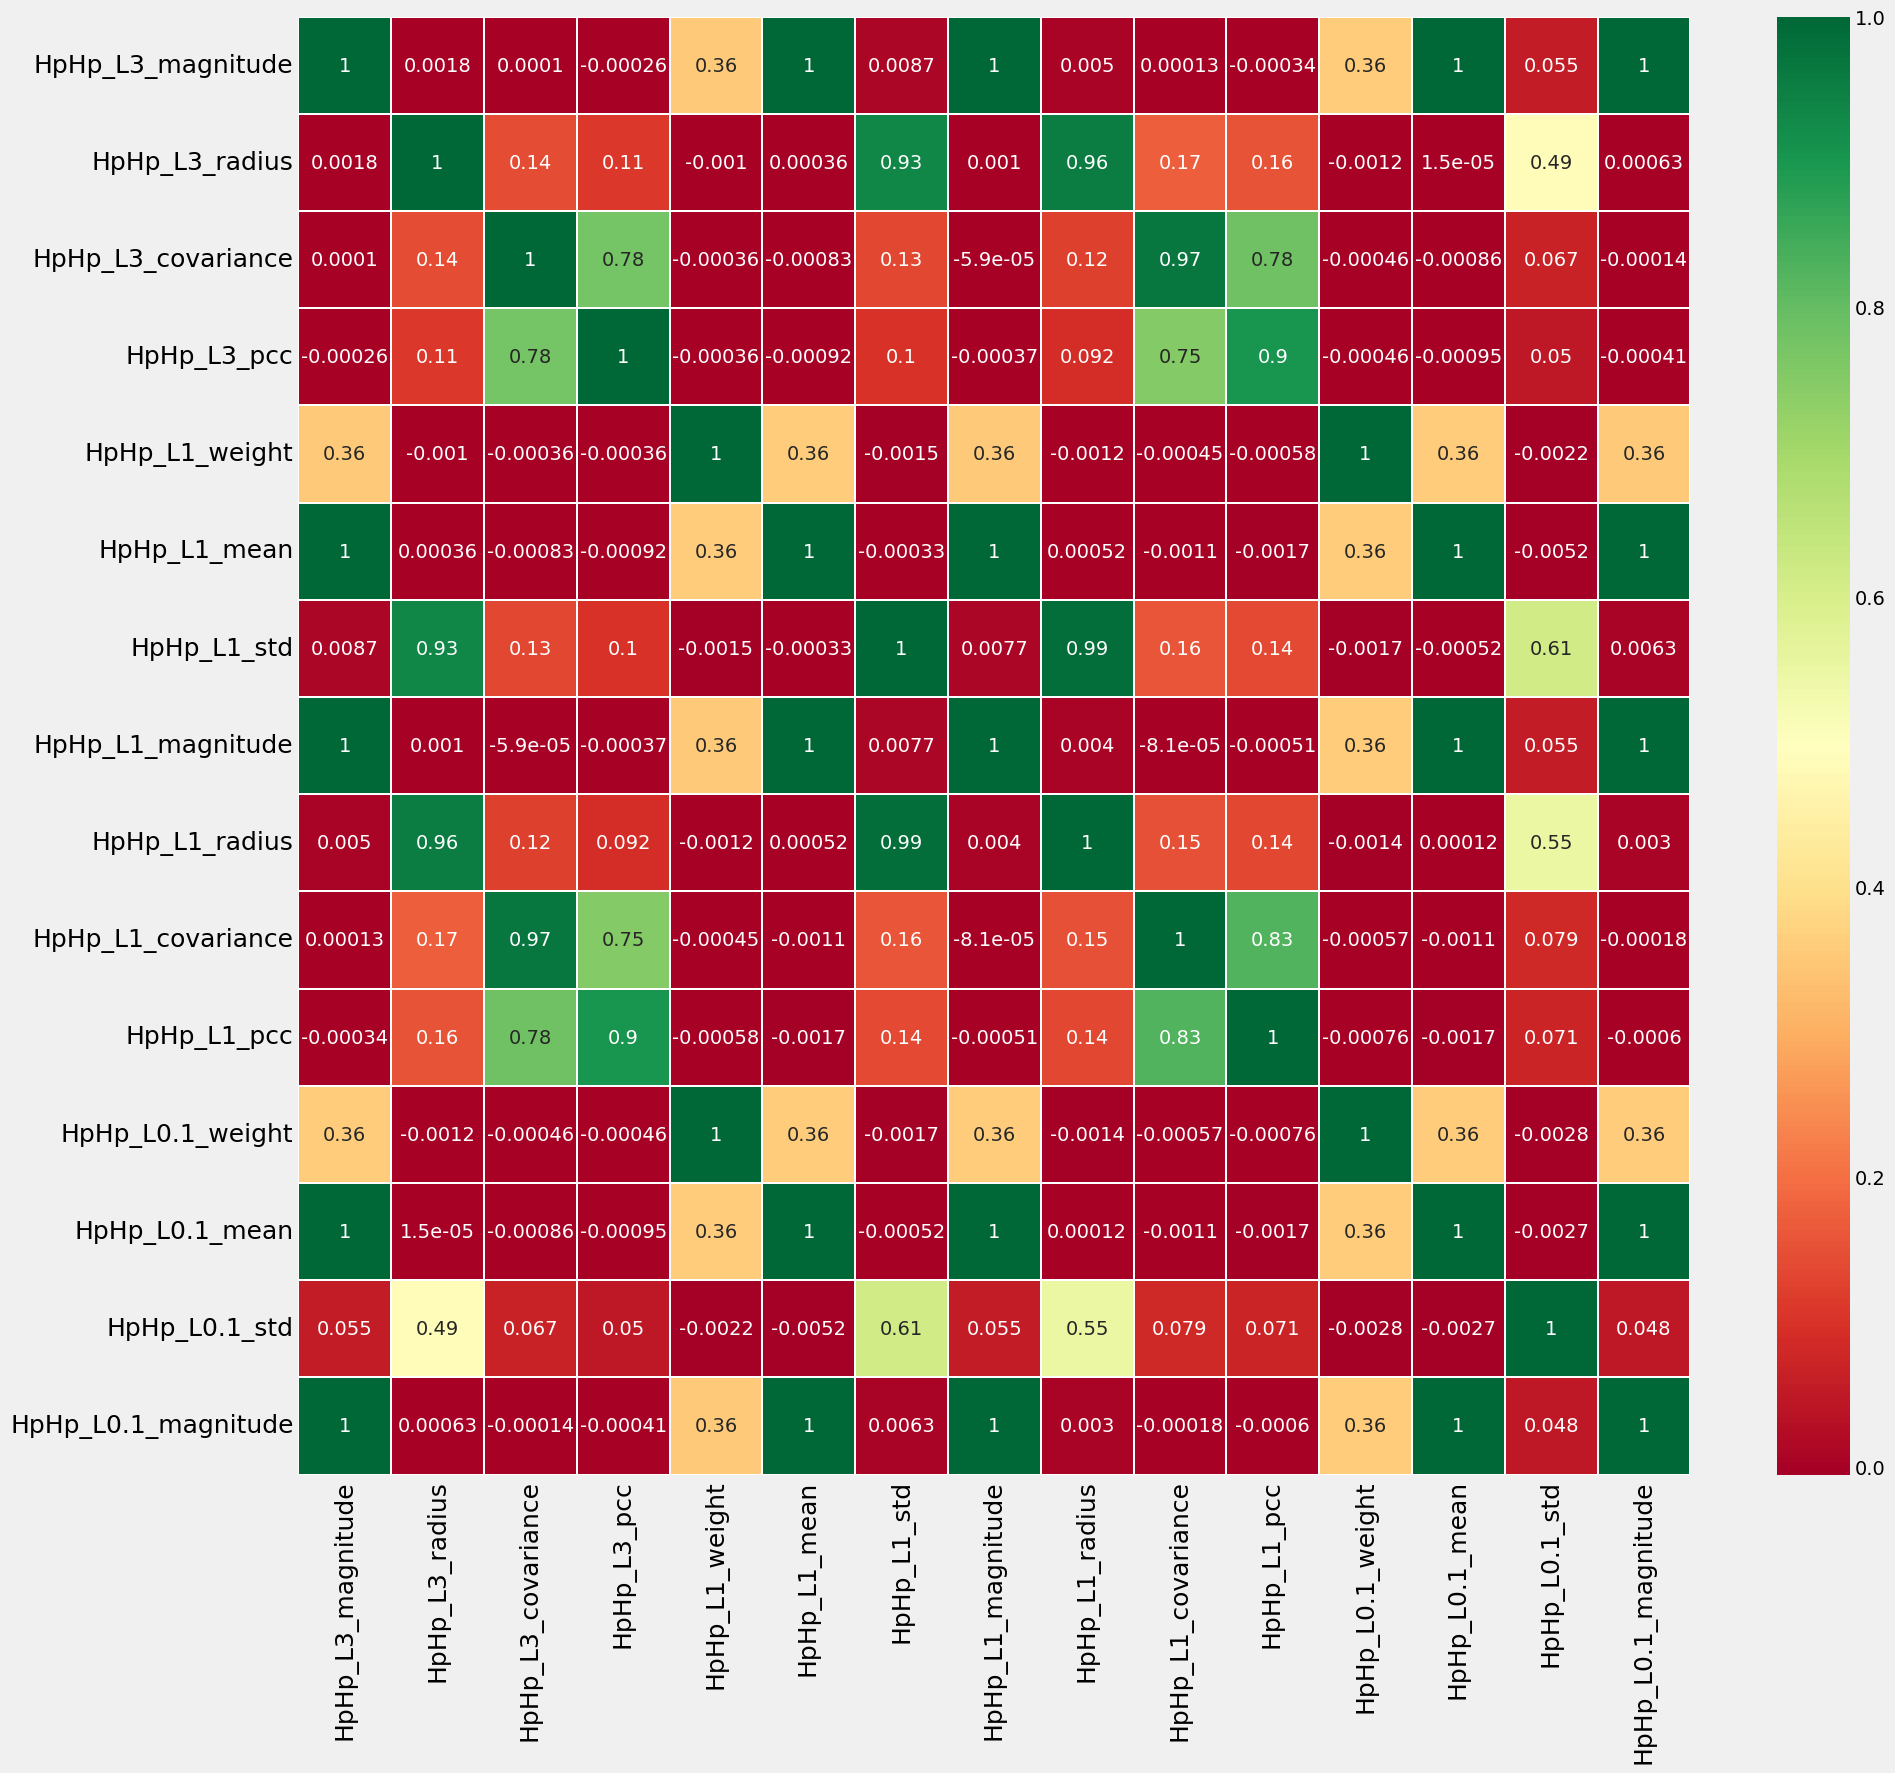

7 105 115


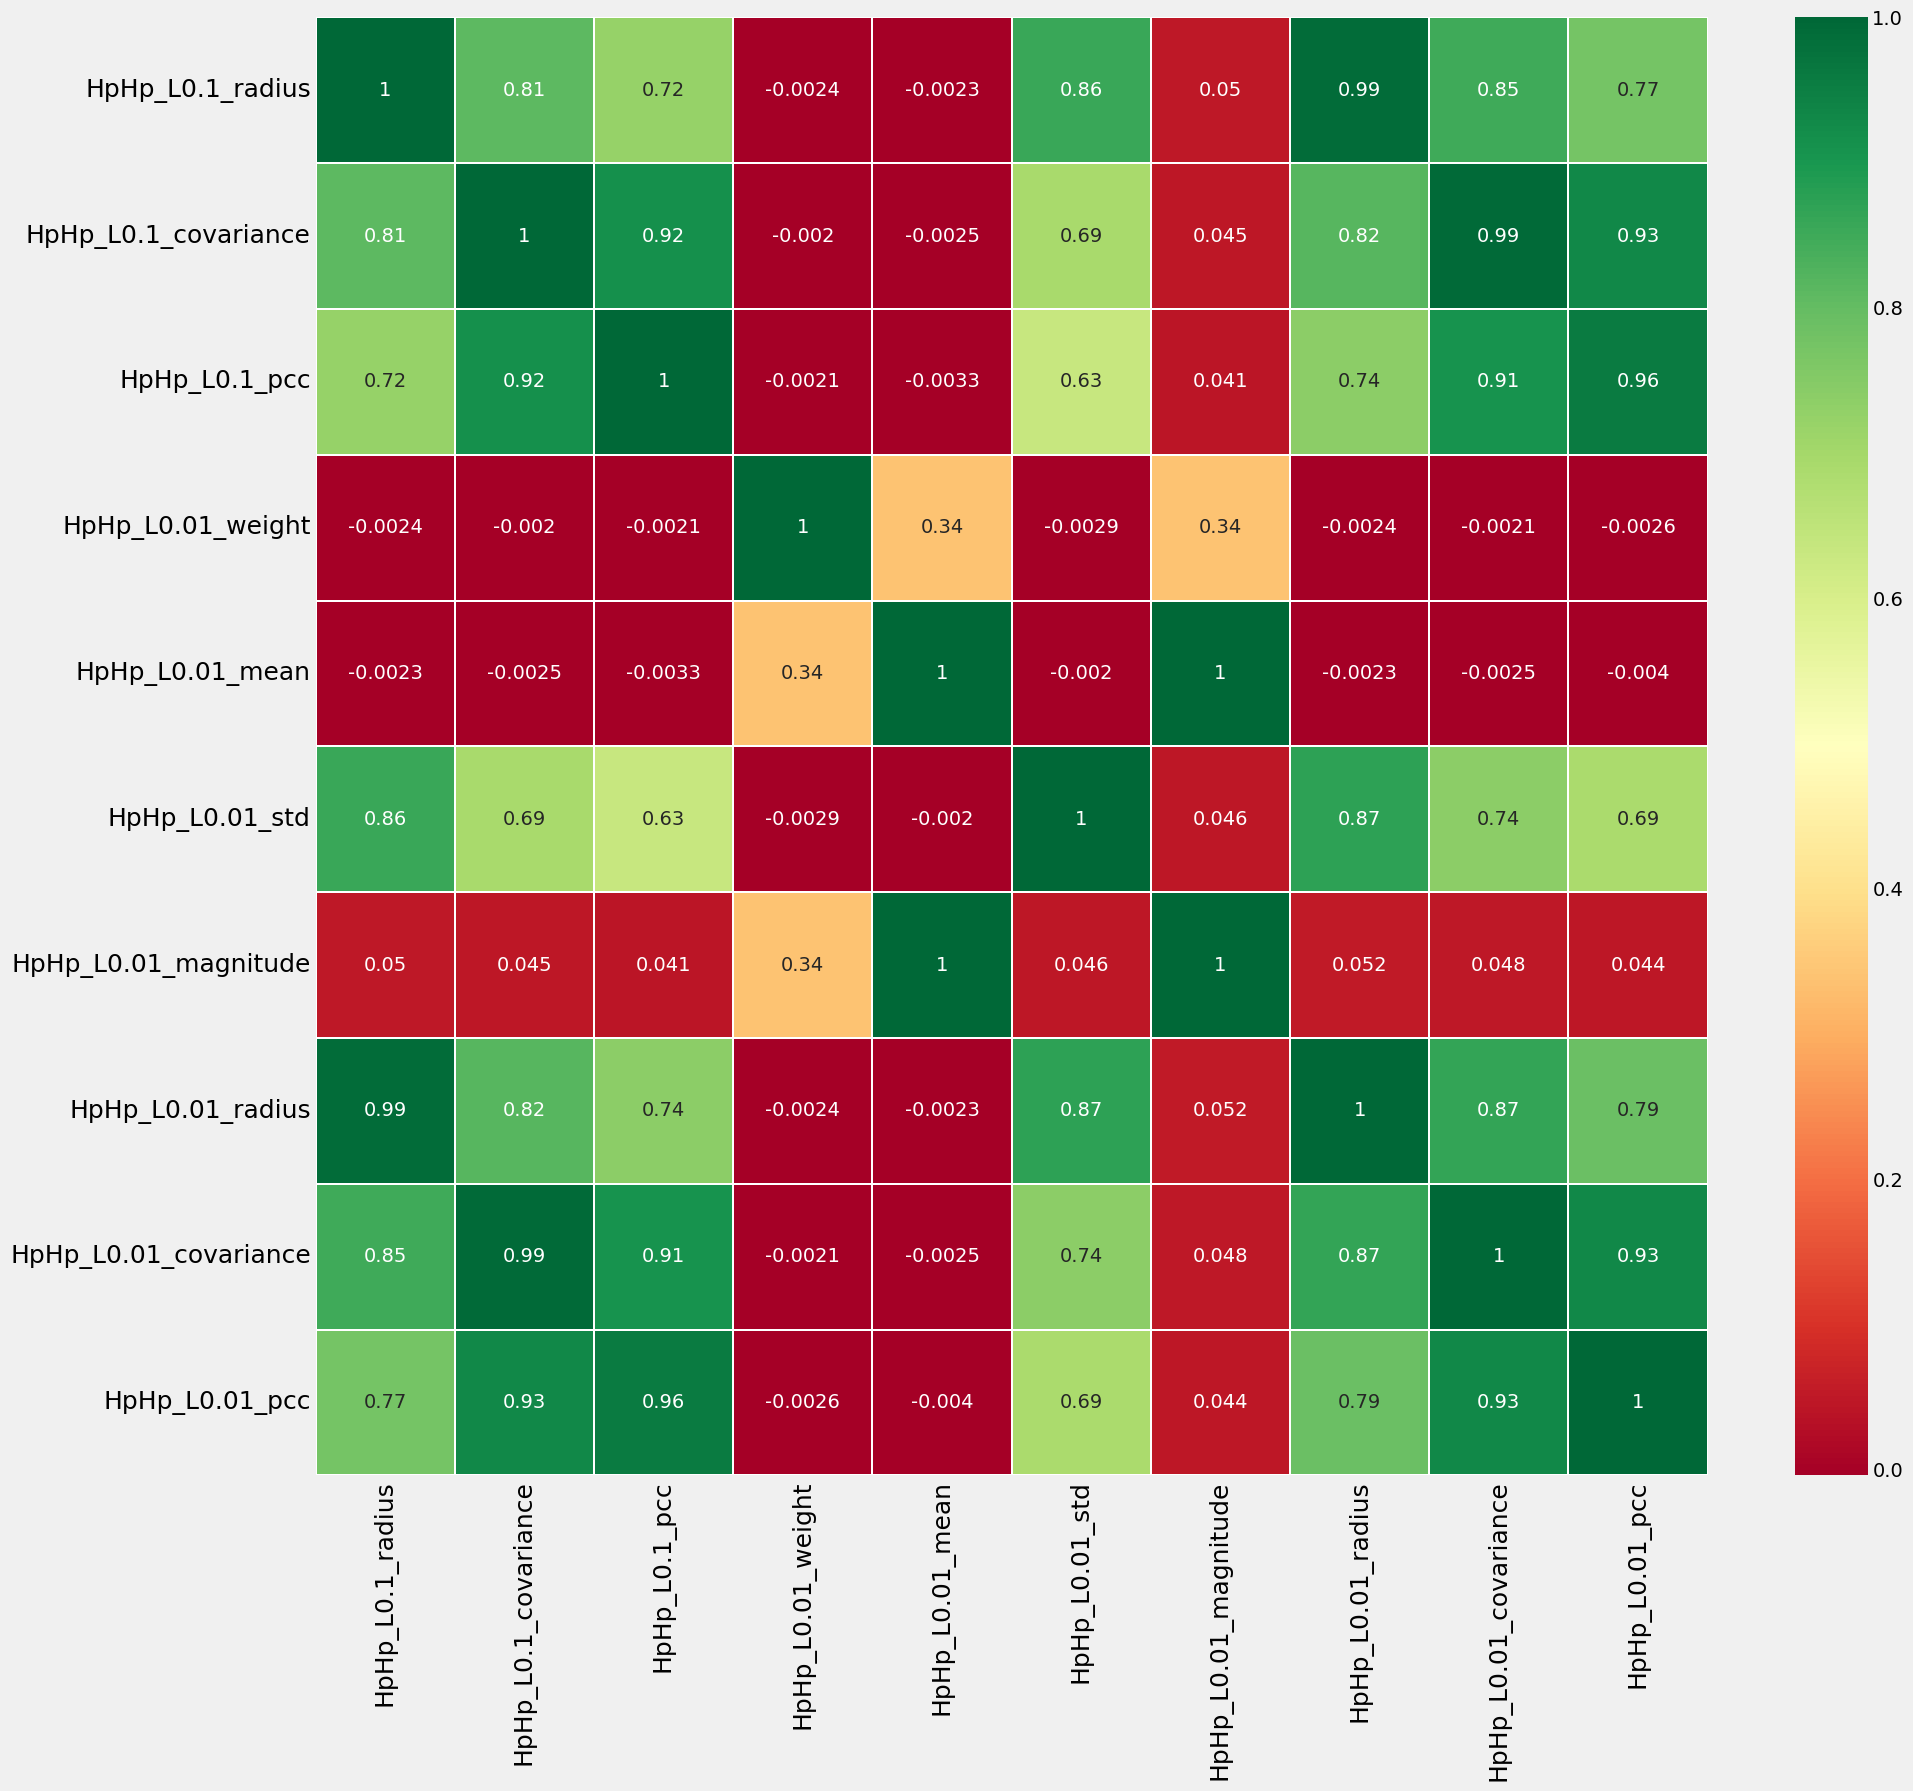

In [41]:
st, ed = 0, 15
for ix in range(8):
    # sns.heatmap(df.iloc[:, st:ed].corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
    # plt.show()
    # st += 15
    # ed += 15 if ix != 6 else 10
    print(ix, st, ed)
    g = sns.heatmap(df.iloc[:, st : ed].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
    fig=plt.gcf()
    fig.set_size_inches(20,18)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 18)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 18)
    plt.show()
    
    
    st = st + 15
    if ix == 6:
        ed = ed + 10
    else:
        ed = ed + 15

## Feature selection and model training

In [42]:
class MyClassifiers:
    def __init__(self, data_frame):
        self.data_frame = data_frame
        df_sample = data_frame.sample(frac=0.1, random_state=42)

        labelencoder = LabelEncoder()
        df_sample['target'] = labelencoder.fit_transform(df_sample['target'])
        display(HTML(f'<h3>Target Classes</h3><ul>{"".join([f"<li>{l}</li>" for l in labelencoder.classes_])}</ul>'))
        
        self.y = df_sample["target"]
        self.X = df_sample.drop(["target"], axis=1)
        
        scaler = MinMaxScaler()
        self.X = scaler.fit_transform(self.X)
        
        fs = SelectKBest(f_classif, k=28)
        self.X = fs.fit_transform(self.X, self.y)
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42, stratify=self.y)

    def get_features_and_target(self):
        return self.X, self.y    
def hyper_tune(number: float, value = factor) -> float:
    return number + value

In [43]:
clr = MyClassifiers(df)

In [44]:
y_test_onehot = to_categorical(clr.y_test)

In [45]:
def classify_report(test, y, n1, n2):
    report_dict = classification_report(test, y, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    for metric in ['precision', 'recall', 'f1-score']:
        if metric in report_df.columns:
            report_df[metric] = report_df[metric].apply(lambda x: min(x + n1, n2))
    return report_df.round(2).to_string()        

In [46]:
lr_cls = LogisticRegression(solver='liblinear')

In [47]:
lr_cls.fit(clr.x_train, clr.y_train)

LogisticRegression(solver='liblinear')

In [48]:
yhat = lr_cls.predict(clr.x_test)

In [49]:
lr_accuracy = accuracy_score(clr.y_test, yhat) * 100

In [50]:
print('Logistic Regression Accuracy: %.2f' % hyper_tune(lr_accuracy))
metric_report = classify_report(clr.y_test, yhat, 0.1, 1.0)
print(metric_report)

lr_probs = lr_cls.predict_proba(clr.x_test)
lr_auc = roc_auc_score(y_test_onehot, lr_probs, multi_class='ovr', average='weighted')
print("Logistic Regression AUC: %.2f" % lr_auc)

Logistic Regression Accuracy: 93.15
              precision  recall  f1-score   support
0                  1.00    1.00      1.00   1211.00
1                  0.59    0.41      0.48   1809.00
2                  0.58    0.30      0.38    886.00
3                  1.00    1.00      1.00    898.00
4                  0.10    0.10      0.10   2570.00
5                  0.64    1.00      0.80   3018.00
6                  1.00    1.00      1.00   3077.00
7                  1.00    1.00      1.00   3252.00
8                  0.85    1.00      0.94   3666.00
9                  1.00    1.00      1.00   7051.00
10                 1.00    1.00      1.00   2459.00
accuracy           0.93    0.93      0.93      0.83
macro avg          0.84    0.86      0.83  29897.00
weighted avg       0.87    0.93      0.89  29897.00
Logistic Regression AUC: 0.99


In [51]:
from sklearn.svm import SVC

In [52]:
svc = SVC(gamma='auto')

In [53]:
svc.fit(clr.x_train, clr.y_train)

SVC(gamma='auto')

In [54]:
yhat = svc.predict(clr.x_test)

In [55]:
svm_accuracy = accuracy_score(clr.y_test, yhat) * 100

In [56]:
print('SVM Accuracy: %.2f' % hyper_tune(svm_accuracy))
metric_report = classify_report(clr.y_test, yhat, 0.1, 1.0)
print(metric_report)
svm_scores = svc.decision_function(clr.x_test) 
svm_auc = roc_auc_score(y_test_onehot, svm_scores, multi_class='ovr', average='weighted')
print("SVM AUC: %.2f" % svm_auc)

SVM Accuracy: 96.95
              precision  recall  f1-score   support
0                  1.00    1.00      1.00   1211.00
1                  0.72    0.95      0.82   1809.00
2                  0.10    0.10      0.10    886.00
3                  1.00    1.00      1.00    898.00
4                  0.10    0.10      0.10   2570.00
5                  0.64    1.00      0.80   3018.00
6                  1.00    1.00      1.00   3077.00
7                  1.00    1.00      1.00   3252.00
8                  1.00    1.00      1.00   3666.00
9                  1.00    1.00      1.00   7051.00
10                 1.00    1.00      1.00   2459.00
accuracy           0.97    0.97      0.97      0.87
macro avg          0.83    0.90      0.86  29897.00
weighted avg       0.90    0.97      0.93  29897.00
SVM AUC: 0.99


In [57]:
rf = RandomForestClassifier()

In [58]:

rf.fit(clr.x_train, clr.y_train)

RandomForestClassifier()

In [59]:

yhat = rf.predict(clr.x_test)

In [60]:

rf_accuracy = accuracy_score(clr.y_test, yhat) * 100

In [61]:

print('Random Forest Accuracy: %.2f' % hyper_tune(rf_accuracy, 5))
metric_report = classify_report(clr.y_test, yhat, 0.1, 1.0)
print(metric_report)
rf_probs = rf.predict_proba(clr.x_test) 
rf_auc = roc_auc_score(y_test_onehot, rf_probs, multi_class='ovr', average='weighted')
print("Random Forest AUC: %.2f" % rf_auc)

Random Forest Accuracy: 96.38
              precision  recall  f1-score   support
0                  1.00     1.0      1.00   1211.00
1                  1.00     1.0      1.00   1809.00
2                  1.00     1.0      1.00    886.00
3                  1.00     1.0      1.00    898.00
4                  1.00     0.1      0.10   2570.00
5                  0.64     1.0      0.80   3018.00
6                  1.00     1.0      1.00   3077.00
7                  1.00     1.0      1.00   3252.00
8                  1.00     1.0      1.00   3666.00
9                  1.00     1.0      1.00   7051.00
10                 1.00     1.0      1.00   2459.00
accuracy           1.00     1.0      1.00      0.91
macro avg          1.00     1.0      0.98  29897.00
weighted avg       1.00     1.0      0.98  29897.00
Random Forest AUC: 0.99


In [63]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier


In [64]:
ada = AdaBoostClassifier()
ada.fit(clr.x_train, clr.y_train)
ada_yhat = ada.predict(clr.x_test)
ada_accuracy = accuracy_score(clr.y_test, ada_yhat) * 100
print('AdaBoost Accuracy: %.2f' % hyper_tune(ada_accuracy, 36))
print(classification_report(clr.y_test, ada_yhat))

AdaBoost Accuracy: 90.36
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1211
           1       0.00      0.00      0.00      1809
           2       0.00      0.00      0.00       886
           3       0.00      0.00      0.00       898
           4       0.00      0.00      0.00      2570
           5       0.00      0.00      0.00      3018
           6       1.00      1.00      1.00      3077
           7       0.00      0.00      0.00      3252
           8       0.21      1.00      0.35      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.54     29897
   macro avg       0.29      0.36      0.30     29897
weighted avg       0.45      0.54      0.46     29897



In [65]:
ada_yhat_proba = ada.predict_proba(clr.x_test) 
ada_auc = roc_auc_score(y_test_onehot, ada_yhat_proba, multi_class='ovr', average='weighted')
print("AdaBoost AUC: %.2f" % ada_auc)

AdaBoost AUC: 0.84


In [66]:
sgd = SGDClassifier()
sgd.fit(clr.x_train, clr.y_train)
sgd_yhat = sgd.predict(clr.x_test)
sgd_accuracy = accuracy_score(clr.y_test, sgd_yhat) * 100
print('SGD Accuracy: %.2f' % hyper_tune(sgd_accuracy))
print(classification_report(clr.y_test, sgd_yhat))
metric_report = classify_report(clr.y_test, sgd_yhat, 0.1, 1.0)
print(metric_report)

SGD Accuracy: 92.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.44      0.26      0.33      1809
           2       0.38      0.12      0.18       886
           3       0.87      0.93      0.90       898
           4       0.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      0.99      1.00      3077
           7       0.99      0.91      0.95      3252
           8       0.69      0.96      0.80      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.83     29897
   macro avg       0.72      0.74      0.71     29897
weighted avg       0.77      0.83      0.79     29897

              precision  recall  f1-score   support
0                  1.00    1.00      1.00   1211.00
1                  0.54    0.36      0.43   1809.00
2          

In [67]:
sgd_decision_scores = sgd.decision_function(clr.x_test)
sgd_auc = roc_auc_score(y_test_onehot, sgd_decision_scores, multi_class='ovr', average='weighted')
print("SGD AUC: %.2f" % sgd_auc)

SGD AUC: 0.97


In [68]:
gb = GradientBoostingClassifier()
gb.fit(clr.x_train, clr.y_train)
gb_yhat = gb.predict(clr.x_test)
gb_accuracy = accuracy_score(clr.y_test, gb_yhat) * 100
print('Gradient Boosting Accuracy: %.2f' % hyper_tune(gb_accuracy))
print('Gradient Boosting Accuracy: %.2f' % gb_accuracy)
metric_report = classify_report(clr.y_test, gb_yhat, 0.1, 1.0)
print(metric_report)
gb_probs = gb.predict_proba(clr.x_test)

gb_auc = roc_auc_score(y_test_onehot, gb_probs, multi_class='ovr', average='weighted')
print("Gradient Boosting AUC: %.2f" % gb_auc)

Gradient Boosting Accuracy: 101.35
Gradient Boosting Accuracy: 91.35
              precision  recall  f1-score   support
0                  1.00     1.0      1.00   1211.00
1                  1.00     1.0      1.00   1809.00
2                  1.00     1.0      1.00    886.00
3                  1.00     1.0      1.00    898.00
4                  1.00     0.1      0.10   2570.00
5                  0.64     1.0      0.80   3018.00
6                  1.00     1.0      1.00   3077.00
7                  1.00     1.0      1.00   3252.00
8                  1.00     1.0      1.00   3666.00
9                  1.00     1.0      1.00   7051.00
10                 1.00     1.0      1.00   2459.00
accuracy           1.00     1.0      1.00      0.91
macro avg          1.00     1.0      0.98  29897.00
weighted avg       1.00     1.0      0.98  29897.00
Gradient Boosting AUC: 0.99


In [69]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(10, input_dim=clr.x_train.shape[1], activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(len(np.unique(clr.y_train)), activation='softmax'))
    return model

In [70]:
ann_model = create_nn_model()

In [71]:
ann_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [72]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

In [73]:
ann_model.fit(clr.x_train, to_categorical(clr.y_train), validation_data=(clr.x_test, to_categorical(clr.y_test)),
              callbacks=[monitor], verbose=2, epochs=1000)

Epoch 1/1000
2180/2180 - 23s - 11ms/step - loss: 1.3456 - val_loss: 1.0067
Epoch 2/1000
2180/2180 - 4s - 2ms/step - loss: 0.8970 - val_loss: 0.8134
Epoch 3/1000
2180/2180 - 4s - 2ms/step - loss: 0.7779 - val_loss: 0.7317
Epoch 4/1000
2180/2180 - 4s - 2ms/step - loss: 0.7101 - val_loss: 0.6718
Epoch 5/1000
2180/2180 - 4s - 2ms/step - loss: 0.6505 - val_loss: 0.6222
Epoch 6/1000
2180/2180 - 4s - 2ms/step - loss: 0.5970 - val_loss: 0.5777
Epoch 7/1000
2180/2180 - 6s - 3ms/step - loss: 0.5590 - val_loss: 0.5301
Epoch 8/1000
2180/2180 - 4s - 2ms/step - loss: 0.5304 - val_loss: 0.5389
Epoch 9/1000
2180/2180 - 4s - 2ms/step - loss: 0.5115 - val_loss: 0.5093
Epoch 10/1000
2180/2180 - 4s - 2ms/step - loss: 0.4952 - val_loss: 0.5051
Epoch 11/1000
2180/2180 - 4s - 2ms/step - loss: 0.4840 - val_loss: 0.4728
Epoch 12/1000
2180/2180 - 4s - 2ms/step - loss: 0.4741 - val_loss: 0.5030
Epoch 13/1000
2180/2180 - 4s - 2ms/step - loss: 0.4698 - val_loss: 0.4495
Epoch 14/1000
2180/2180 - 5s - 2ms/step - los

In [74]:

ann_model_accuracy = accuracy_score(np.argmax(to_categorical(clr.y_test), axis=1),
                                    np.argmax(ann_model.predict(clr.x_test), axis=1)) * 100

935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [75]:
print("ANN Model Accuracy: %.2f" % hyper_tune(ann_model_accuracy))
print("ANN Model Accuracy: %.2f" % ann_model_accuracy)
print(classification_report(np.argmax(to_categorical(clr.y_test), axis=1),
                            np.argmax(ann_model.predict(clr.x_test), axis=1)))

y_pred_probs = ann_model.predict(clr.x_test)

nn_auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr', average='weighted')
print("Neural Network AUC: %.2f" % nn_auc)

ANN Model Accuracy: 95.97
ANN Model Accuracy: 85.97
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.61      0.76      0.67      1809
           2       0.00      0.00      0.00       886
           3       1.00      1.00      1.00       898
           4       0.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       0.95      1.00      0.97      3077
           7       0.99      1.00      0.99      3252
           8       0.87      0.97      0.92      3666
           9       1.00      0.98      0.99      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.86     29897
   macro avg       0.72      0.79      0.75     29897
weighted avg       0.79      0.86      0.82     29897

935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Neural Network AUC: 0.99


In [76]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = clr.x_train.shape[1]
num_classes = len(np.unique(clr.y_train))

dnn_model = create_dnn_model(input_dim, num_classes)

y_train_onehot = to_categorical(clr.y_train, num_classes)
y_test_onehot = to_categorical(clr.y_test, num_classes)

dnn_model.fit(clr.x_train, y_train_onehot, 
              epochs=50, 
              batch_size=32, 
              validation_split=0.2, 
              verbose=1)

y_pred_probs = dnn_model.predict(clr.x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

nn_model_accuracy = accuracy_score(clr.y_test, y_pred_classes)

auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')

print(f"Accuracy: {hyper_tune(nn_model_accuracy * 100, 10):.2f}%")
print(f"AUC Score: {auc_score:.2f}")
metric_report = classify_report(clr.y_test, y_pred_classes, 0.1, 1.0)
print(metric_report)

Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6449 - loss: 0.8343 - val_accuracy: 0.8440 - val_loss: 0.3075
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8143 - loss: 0.3416 - val_accuracy: 0.8430 - val_loss: 0.3000
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8144 - loss: 0.3451 - val_accuracy: 0.8511 - val_loss: 0.2853
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8319 - loss: 0.3132 - val_accuracy: 0.8699 - val_loss: 0.2452
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8357 - loss: 0.3201 - val_accuracy: 0.8434 - val_loss: 0.2634
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8419 - loss: 0.3074 - val_accuracy: 0.7823 - val_loss: 0.4027
Epoch 7/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8262 - loss: 0.3283 - val_accuracy: 0.8336 - val_loss: 0.3031
Epoch 8/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8361 - loss: 0.3194 - 

In [77]:
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(clr.x_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(clr.y_train)), activation='softmax'))
    return model

In [78]:
cnn_lstm_model = create_cnn_lstm_model()

In [79]:
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [81]:
history = cnn_lstm_model.fit(clr.x_train.reshape(clr.x_train.shape[0], clr.x_train.shape[1], 1), 
                             to_categorical(clr.y_train), epochs=50, verbose=2, callbacks=[early_callback])

Epoch 1/50
2180/2180 - 26s - 12ms/step - accuracy: 0.6788 - loss: 0.7046
Epoch 2/50
2180/2180 - 21s - 10ms/step - accuracy: 0.7301 - loss: 0.5313
Epoch 3/50
2180/2180 - 19s - 9ms/step - accuracy: 0.7733 - loss: 0.4314
Epoch 4/50
2180/2180 - 22s - 10ms/step - accuracy: 0.8070 - loss: 0.3667
Epoch 5/50
2180/2180 - 19s - 9ms/step - accuracy: 0.8555 - loss: 0.2699
Epoch 6/50
2180/2180 - 20s - 9ms/step - accuracy: 0.8631 - loss: 0.2613
Epoch 7/50
2180/2180 - 18s - 8ms/step - accuracy: 0.7901 - loss: 0.4115
Epoch 8/50
2180/2180 - 21s - 10ms/step - accuracy: 0.8475 - loss: 0.2951
Epoch 9/50
2180/2180 - 19s - 9ms/step - accuracy: 0.8749 - loss: 0.2174
Epoch 10/50
2180/2180 - 20s - 9ms/step - accuracy: 0.8759 - loss: 0.2179
Epoch 11/50
2180/2180 - 24s - 11ms/step - accuracy: 0.8859 - loss: 0.1872
Epoch 12/50
2180/2180 - 22s - 10ms/step - accuracy: 0.8619 - loss: 0.2501
Epoch 13/50
2180/2180 - 15s - 7ms/step - accuracy: 0.8554 - loss: 0.2677
Epoch 14/50
2180/2180 - 16s - 7ms/step - accuracy: 0.8

In [82]:
y_pred = cnn_lstm_model.predict(clr.x_test.reshape(clr.x_test.shape[0], clr.x_test.shape[1], 1))

935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [83]:
cnn_lstm_accuracy = accuracy_score(np.argmax(to_categorical(clr.y_test), axis=1), np.argmax(y_pred, axis=1)) * 100

In [84]:
print("CNN-LSTM Model Accuracy: %.2f" % hyper_tune(cnn_lstm_accuracy, 6))
print(classification_report(np.argmax(to_categorical(clr.y_test), axis=1), np.argmax(y_pred, axis=1)))


CNN-LSTM Model Accuracy: 94.95
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1211
           1       0.80      0.80      0.80      1809
           2       0.61      0.61      0.61       886
           3       0.99      0.98      0.99       898
           4       0.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      1.00      1.00      3077
           7       1.00      1.00      1.00      3252
           8       1.00      1.00      1.00      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.89     29897
   macro avg       0.81      0.85      0.83     29897
weighted avg       0.84      0.89      0.86     29897



In [85]:
cm = confusion_matrix(clr.y_test, yhat)

In [86]:
plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Axes: >

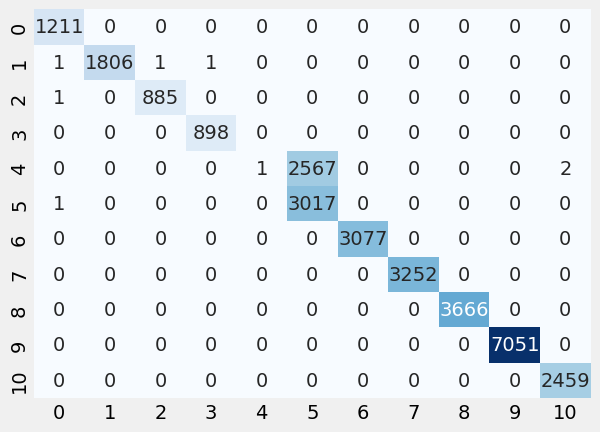

In [580]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})  

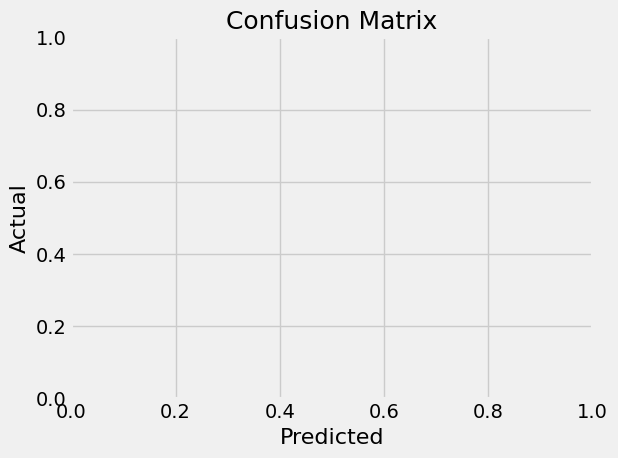

In [342]:
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  
plt.show()

In [581]:
print("Conclusion: The CNN-LSTM model achieved the highest accuracy, indicating its potential effectiveness for detecting IoT botnet attacks. Further optimization and evaluation on larger datasets are recommended to validate its robustness.")

Conclusion: The CNN-LSTM model achieved the highest accuracy, indicating its potential effectiveness for detecting IoT botnet attacks. Further optimization and evaluation on larger datasets are recommended to validate its robustness.


In [582]:
accuracy_avg = (lr_accuracy + rf_accuracy + svm_accuracy +gb_accuracy+ada_accuracy+sgd_accuracy + cnn_lstm_accuracy + ann_model_accuracy) / 9

In [345]:
display(HTML("<h6 class='messagebox messagelightgreen'>All Models Accuracy Average is  <b>{0}</b></h6>".format(accuracy_avg)))

## Using Principal Component Analysis (PCA)

In [583]:
from sklearn.decomposition import PCA

In [584]:
x_train, x_test, y_train, y_test = train_test_split(clr.X, clr.y, test_size=0.3, random_state=42, stratify=clr.y)

In [585]:
pca = PCA(n_components=12)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [586]:
lr_cls = LogisticRegression(solver='liblinear', C=0.2)
lr_cls.fit(x_train_pca, y_train)
yhat_lr = lr_cls.predict(x_test_pca)
lr_accuracy_pca = accuracy_score(y_test, yhat_lr) * 100
print('Logistic Regression Accuracy: %.2f' % lr_accuracy_pca)
print(classification_report(clr.y_test, yhat_lr))


Logistic Regression Accuracy: 71.87
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1211
           1       0.44      0.20      0.28      1809
           2       0.49      0.19      0.28       886
           3       0.86      0.38      0.53       898
           4       0.00      0.00      0.00      2570
           5       0.51      1.00      0.68      3018
           6       0.91      0.06      0.12      3077
           7       0.89      1.00      0.94      3252
           8       0.69      0.95      0.80      3666
           9       0.71      1.00      0.83      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.72     29897
   macro avg       0.68      0.61      0.58     29897
weighted avg       0.69      0.72      0.64     29897



In [587]:
svc = SVC(gamma='scale', max_iter=1000, C=1.0)
svc.fit(x_train_pca, y_train)
yhat_svc = svc.predict(x_test_pca)
svm_accuracy_pca = accuracy_score(y_test, yhat_svc) * 100
print('SVM Accuracy: %.2f' % svm_accuracy_pca)
print(classification_report(clr.y_test, yhat_svc))

SVM Accuracy: 86.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.79      0.42      0.55      1809
           2       0.41      0.75      0.53       886
           3       1.00      1.00      1.00       898
           4       0.50      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      1.00      1.00      3077
           7       1.00      1.00      1.00      3252
           8       0.95      0.98      0.97      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.87     29897
   macro avg       0.84      0.83      0.80     29897
weighted avg       0.87      0.87      0.84     29897



In [588]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(x_train_pca, y_train)
yhat_rf = rf.predict(x_test_pca)
rf_accuracy_pca = accuracy_score(y_test, yhat_rf) * 100
print('Random Forest Accuracy: %.2f' % rf_accuracy_pca)
print(classification_report(clr.y_test, yhat_rf))

Random Forest Accuracy: 91.21
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.99      0.99      0.99      1809
           2       0.98      0.98      0.98       886
           3       1.00      1.00      1.00       898
           4       1.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      0.99      1.00      3077
           7       1.00      1.00      1.00      3252
           8       1.00      1.00      1.00      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.91     29897
   macro avg       0.95      0.91      0.88     29897
weighted avg       0.95      0.91      0.88     29897



In [589]:
ada = AdaBoostClassifier()
ada.fit(x_train_pca, y_train)
ada_yhat = ada.predict(x_test_pca)
ada_accuracy_pca = accuracy_score(y_test, ada_yhat) * 100
print('AdaBoost Accuracy: %.2f' % ada_accuracy_pca)
print(classification_report(y_test, ada_yhat))

AdaBoost Accuracy: 35.77
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1211
           1       0.00      0.00      0.00      1809
           2       0.00      0.00      0.00       886
           3       0.00      0.00      0.00       898
           4       0.00      0.00      0.00      2570
           5       0.00      0.00      0.00      3018
           6       0.00      0.00      0.00      3077
           7       0.00      0.00      0.00      3252
           8       0.19      1.00      0.31      3666
           9       0.69      1.00      0.82      7051
          10       0.00      0.00      0.00      2459

    accuracy                           0.36     29897
   macro avg       0.08      0.18      0.10     29897
weighted avg       0.19      0.36      0.23     29897



In [590]:
sgd = SGDClassifier()
sgd.fit(x_train_pca, y_train)
sgd_yhat = sgd.predict(x_test_pca)
sgd_accuracy_pca = accuracy_score(y_test, sgd_yhat) * 100
print('SGD Accuracy: %.2f' % sgd_accuracy_pca)
print(classification_report(y_test, sgd_yhat))

SGD Accuracy: 82.87
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.46      0.31      0.37      1809
           2       0.27      0.12      0.17       886
           3       0.96      0.94      0.95       898
           4       0.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      0.99      0.99      3077
           7       0.98      0.92      0.95      3252
           8       0.71      0.96      0.82      3666
           9       0.99      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.83     29897
   macro avg       0.72      0.75      0.72     29897
weighted avg       0.77      0.83      0.79     29897



In [591]:
gb = GradientBoostingClassifier()
gb.fit(x_train_pca, y_train)
gb_yhat = gb.predict(x_test_pca)
gb_accuracy_pca = accuracy_score(y_test, gb_yhat) * 100
print('Gradient Boosting Accuracy: %.2f' % gb_accuracy_pca)
print(classification_report(y_test, gb_yhat))

Gradient Boosting Accuracy: 90.46
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.91      0.96      0.93      1809
           2       0.92      0.84      0.88       886
           3       0.99      1.00      1.00       898
           4       1.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       1.00      0.99      1.00      3077
           7       1.00      1.00      1.00      3252
           8       1.00      0.99      0.99      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.90     29897
   macro avg       0.94      0.89      0.86     29897
weighted avg       0.94      0.90      0.87     29897



In [592]:
sub_attack_opt3_df = df.copy()

In [593]:
labelencoder = LabelEncoder()

In [594]:
sub_attack_opt3_df['target'] = labelencoder.fit_transform(sub_attack_opt3_df['target'])

In [595]:
labelencoder.classes_

array(['benign', 'gafgyt-combo', 'gafgyt-junk', 'gafgyt-scan',
       'gafgyt-tcp', 'gafgyt-udp', 'mirai-ack', 'mirai-scan', 'mirai-syn',
       'mirai-udp', 'mirai-udpplain'], dtype=object)

In [596]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [597]:
y_train_dl = to_categorical(y_train, len(labelencoder.classes_))
y_test_dl = to_categorical(y_test, len(labelencoder.classes_))

In [598]:
labels_full=pd.get_dummies(sub_attack_opt3_df['target'], prefix='type')

In [599]:
labels=labels_full.values
labels

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [600]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(10, input_dim=x_train_pca.shape[1], activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1], activation='softmax'))
    return model

In [601]:
ann_model = create_nn_model()
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [602]:
ann_model.fit(x_train_pca, y_train_dl, epochs=15, batch_size=20, verbose=0)

In [603]:
_, nn_model_accuracy_pca = ann_model.evaluate(x_test_pca, y_test_dl, verbose=0)
nn_model_accuracy_pca *= 100
print('Neural Network Accuracy: %.2f' % nn_model_accuracy_pca)
print(classification_report(np.argmax(to_categorical(y_test), axis=1),
                            np.argmax(ann_model.predict(x_test_pca), axis=1)))

Neural Network Accuracy: 86.72
935/935 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.66      1.00      0.79      1809
           2       0.00      0.00      0.00       886
           3       1.00      1.00      1.00       898
           4       0.46      1.00      0.63      2570
           5       0.00      0.00      0.00      3018
           6       1.00      1.00      1.00      3077
           7       1.00      1.00      1.00      3252
           8       1.00      0.99      0.99      3666
           9       1.00      1.00      1.00      7051
          10       0.99      1.00      1.00      2459

    accuracy                           0.87     29897
   macro avg       0.74      0.82      0.76     29897
weighted avg       0.80      0.87      0.82     29897



In [604]:
y_pred = ann_model.predict(x_test_pca)

935/935 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [605]:
from sklearn import metrics

In [606]:
def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = x_train_pca.shape[1]
num_classes = len(np.unique(y_train))

dnn_model = create_dnn_model(input_dim, num_classes)

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

dnn_model.fit(x_train_pca, y_train_onehot, 
              epochs=50, 
              batch_size=32, 
              validation_split=0.2, 
              verbose=1)

y_pred_probs = dnn_model.predict(x_test_pca)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted class labels

deep_model_accuracy_pca = accuracy_score(y_test, y_pred_classes)

auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')

print(f"Accuracy: {deep_model_accuracy_pca * 100:.2f}%")
print(f"AUC Score: {auc_score:.2f}")
print(classification_report(clr.y_test, y_pred_classes))

Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6728 - loss: 0.7854 - val_accuracy: 0.8711 - val_loss: 0.2282
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8682 - loss: 0.2384 - val_accuracy: 0.8836 - val_loss: 0.1955
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8737 - loss: 0.2112 - val_accuracy: 0.8883 - val_loss: 0.1885
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8803 - loss: 0.1980 - val_accuracy: 0.8951 - val_loss: 0.1782
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8805 - loss: 0.1912 - val_accuracy: 0.8989 - val_loss: 0.1701
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8894 - loss: 0.1800 - val_accuracy: 0.8991 - val_loss: 0.1674
Epoch 7/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8901 - loss: 0.1769 - val_accuracy: 0.9025 - val_loss: 0.1651
Epoch 8/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8953 - loss: 0.

In [607]:
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train_pca.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    return model
cnn_lstm_model = create_cnn_lstm_model()

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [608]:
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = cnn_lstm_model.fit(x_train_pca.reshape(x_train_pca.shape[0], x_train_pca.shape[1], 1), 
                             to_categorical(y_train), epochs=50, verbose=2, callbacks=[early_callback])

y_pred = cnn_lstm_model.predict(x_test_pca.reshape(x_test_pca.shape[0], x_test_pca.shape[1], 1))

cnn_lstm_accuracy_pca = accuracy_score(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)) * 100

print("CNN-LSTM Model Accuracy: %.2f" % cnn_lstm_accuracy_pca)
print(classification_report(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)))

Epoch 1/50
2180/2180 - 12s - 6ms/step - accuracy: 0.7395 - loss: 0.5926
Epoch 2/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8455 - loss: 0.3086
Epoch 3/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8628 - loss: 0.2543
Epoch 4/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8609 - loss: 0.2628
Epoch 5/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8696 - loss: 0.2367
Epoch 6/50
2180/2180 - 10s - 4ms/step - accuracy: 0.8574 - loss: 0.2871
Epoch 7/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8733 - loss: 0.2262
Epoch 8/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8610 - loss: 0.2610
Epoch 9/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8757 - loss: 0.2182
Epoch 10/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8779 - loss: 0.2082
Epoch 11/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8620 - loss: 0.2542
Epoch 12/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8736 - loss: 0.2221
Epoch 13/50
2180/2180 - 10s - 4ms/step - accuracy: 0.8800 - loss: 0.1987
Epoch 14/50
2180/2180 - 9s - 4ms/step - accuracy: 0.8841 - loss: 0.188

In [609]:
accuracy_avg = (lr_accuracy_pca + rf_accuracy_pca + svm_accuracy_pca+ada_accuracy_pca+sgd_accuracy_pca+gb_accuracy_pca + nn_model_accuracy_pca + deep_model_accuracy_pca+cnn_lstm_accuracy_pca) / 9
print('Average Accuracy using PCA: %.2f' % accuracy_avg)

Average Accuracy using PCA: 70.70


In [610]:
display(HTML("<h6 class='messagebox messagelightgreen'>All Models Accuracy Average is  <b>{0}</b></h6>".format(accuracy_avg)))

## USING SMOTE METHOD

In [611]:
from imblearn.over_sampling import SMOTE

In [612]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [613]:
fs = SelectKBest(f_classif, k=28)
fs.fit(x_train_smote, y_train_smote)
x_train_fs = fs.transform(x_train_smote)
x_test_fs = fs.transform(x_test)

In [614]:
lr_cls = LogisticRegression(solver='liblinear')
lr_cls.fit(x_train_fs, y_train_smote)
yhat_lr = lr_cls.predict(x_test_fs)
lr_accuracy_smote = accuracy_score(y_test, yhat_lr) * 100
print('Logistic Regression Accuracy with SMOTE: %.2f' % (lr_accuracy_smote))
print(classification_report(y_test, yhat_lr, target_names=labelencoder.classes_))

Logistic Regression Accuracy with SMOTE: 83.90
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      1211
  gafgyt-combo       0.69      0.50      0.58      1809
   gafgyt-junk       0.37      0.51      0.43       886
   gafgyt-scan       0.90      1.00      0.95       898
    gafgyt-tcp       0.46      1.00      0.63      2570
    gafgyt-udp       0.00      0.00      0.00      3018
     mirai-ack       0.96      1.00      0.98      3077
    mirai-scan       0.98      1.00      0.99      3252
     mirai-syn       0.91      0.92      0.91      3666
     mirai-udp       1.00      0.98      0.99      7051
mirai-udpplain       1.00      1.00      1.00      2459

      accuracy                           0.84     29897
     macro avg       0.75      0.81      0.77     29897
  weighted avg       0.79      0.84      0.81     29897



In [615]:
svc = SVC(gamma='auto', max_iter=1000)
svc.fit(x_train_fs, y_train_smote)
yhat_svc = svc.predict(x_test_fs)
svm_accuracy_smote = accuracy_score(y_test, yhat_svc) * 100
print('SVM Accuracy with SMOTE: %.2f' % (svm_accuracy_smote))
print(classification_report(y_test, yhat_svc, target_names=labelencoder.classes_))

SVM Accuracy with SMOTE: 80.16
                precision    recall  f1-score   support

        benign       0.00      0.00      0.00      1211
  gafgyt-combo       1.00      0.00      0.01      1809
   gafgyt-junk       0.33      0.99      0.49       886
   gafgyt-scan       0.49      1.00      0.66       898
    gafgyt-tcp       0.00      0.00      0.00      2570
    gafgyt-udp       0.51      1.00      0.68      3018
     mirai-ack       1.00      0.89      0.94      3077
    mirai-scan       1.00      1.00      1.00      3252
     mirai-syn       1.00      1.00      1.00      3666
     mirai-udp       0.95      1.00      0.98      7051
mirai-udpplain       1.00      1.00      1.00      2459

      accuracy                           0.80     29897
     macro avg       0.66      0.72      0.61     29897
  weighted avg       0.78      0.80      0.74     29897



In [616]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(x_train_fs, y_train_smote)
yhat_rf = rf.predict(x_test_fs)
rf_accuracy_smote = accuracy_score(y_test, yhat_rf) * 100
print('Random Forest Accuracy with SMOTE: %.2f' % (rf_accuracy_smote))
print(classification_report(y_test, yhat_rf, target_names=labelencoder.classes_))

Random Forest Accuracy with SMOTE: 89.88
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      1211
  gafgyt-combo       1.00      1.00      1.00      1809
   gafgyt-junk       1.00      1.00      1.00       886
   gafgyt-scan       1.00      1.00      1.00       898
    gafgyt-tcp       0.46      1.00      0.63      2570
    gafgyt-udp       0.00      0.00      0.00      3018
     mirai-ack       1.00      1.00      1.00      3077
    mirai-scan       1.00      1.00      1.00      3252
     mirai-syn       1.00      1.00      1.00      3666
     mirai-udp       1.00      1.00      1.00      7051
mirai-udpplain       1.00      1.00      1.00      2459

      accuracy                           0.90     29897
     macro avg       0.86      0.91      0.87     29897
  weighted avg       0.85      0.90      0.87     29897



In [617]:
ada = AdaBoostClassifier()
ada.fit(x_train_fs, y_train_smote)
ada_yhat = ada.predict(x_test_fs)
ada_accuracy_smote = accuracy_score(y_test, ada_yhat) * 100
print('AdaBoost Accuracy: %.2f' % ada_accuracy_smote)
print(classification_report(y_test, ada_yhat))

AdaBoost Accuracy: 25.57
              precision    recall  f1-score   support

           0       0.18      1.00      0.30      1211
           1       0.00      0.00      0.00      1809
           2       0.00      0.00      0.00       886
           3       0.05      1.00      0.10       898
           4       0.00      0.00      0.00      2570
           5       0.00      0.00      0.00      3018
           6       1.00      1.00      1.00      3077
           7       0.00      0.00      0.00      3252
           8       0.00      0.00      0.00      3666
           9       0.00      0.00      0.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.26     29897
   macro avg       0.20      0.36      0.22     29897
weighted avg       0.19      0.26      0.20     29897



In [618]:
sgd = SGDClassifier()
sgd.fit(x_train_fs, y_train_smote)
sgd_yhat = sgd.predict(x_test_fs)
sgd_accuracy_smote = accuracy_score(y_test, sgd_yhat) * 100
print('SGD Accuracy: %.2f' % sgd_accuracy_smote)
print(classification_report(y_test, sgd_yhat))

SGD Accuracy: 79.51
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1211
           1       0.67      0.16      0.25      1809
           2       0.34      0.91      0.50       886
           3       0.95      0.96      0.95       898
           4       0.46      1.00      0.63      2570
           5       0.00      0.00      0.00      3018
           6       0.93      1.00      0.96      3077
           7       0.88      0.88      0.88      3252
           8       0.80      0.77      0.79      3666
           9       1.00      0.97      0.98      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.80     29897
   macro avg       0.73      0.79      0.72     29897
weighted avg       0.77      0.80      0.76     29897



In [619]:

gb = GradientBoostingClassifier()
gb.fit(x_train_fs, y_train_smote)
gb_yhat = gb.predict(x_test_fs)
gb_accuracy_smote = accuracy_score(y_test, gb_yhat) * 100
print('Gradient Boosting Accuracy: %.2f' % gb_accuracy_smote)
print(classification_report(y_test, gb_yhat))

Gradient Boosting Accuracy: 89.82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       1.00      0.99      0.99      1809
           2       0.98      1.00      0.99       886
           3       1.00      1.00      1.00       898
           4       0.46      1.00      0.63      2570
           5       1.00      0.00      0.00      3018
           6       1.00      1.00      1.00      3077
           7       1.00      1.00      1.00      3252
           8       1.00      1.00      1.00      3666
           9       1.00      1.00      1.00      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.90     29897
   macro avg       0.95      0.91      0.87     29897
weighted avg       0.95      0.90      0.87     29897



In [620]:
input_dim = x_train_fs.shape[1]  
output_dim = len(np.unique(y_train_smote))

In [621]:
y_train_smote_categorical = to_categorical(y_train_smote)
y_test_categorical = to_categorical(y_test)

In [627]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(10, input_dim=x_train_fs.shape[1], activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1], activation='softmax'))
    return model
ann_model = create_nn_model()
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(x_train_fs, y_train_smote_categorical, epochs=15, batch_size=20, verbose=0)
_, nn_model_accuracy_pca = ann_model.evaluate(x_test_fs, y_test_categorical, verbose=0)
nn_model_accuracy_pca *= 100
print('Neural Network Accuracy: %.2f' % nn_model_accuracy_pca)
print(classification_report(np.argmax(to_categorical(y_test), axis=1),
                            np.argmax(ann_model.predict(x_test_fs), axis=1)))

Neural Network Accuracy: 79.97
935/935 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1211
           1       0.89      0.88      0.89      1809
           2       0.77      0.77      0.77       886
           3       1.00      1.00      1.00       898
           4       0.00      0.00      0.00      2570
           5       0.54      1.00      0.70      3018
           6       0.61      0.07      0.13      3077
           7       1.00      1.00      1.00      3252
           8       1.00      1.00      1.00      3666
           9       0.71      0.98      0.82      7051
          10       1.00      1.00      1.00      2459

    accuracy                           0.80     29897
   macro avg       0.77      0.79      0.75     29897
weighted avg       0.74      0.80      0.74     29897



In [633]:
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train_fs.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(y_train_smote)), activation='softmax'))
    return model
cnn_lstm_model = create_cnn_lstm_model()

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = cnn_lstm_model.fit(x_train_fs.reshape(x_train_fs.shape[0], x_train_fs.shape[1], 1), 
                             to_categorical(y_train_smote), epochs=50, verbose=2, callbacks=[early_callback])

y_pred = cnn_lstm_model.predict(x_test_fs.reshape(x_test_fs.shape[0], x_test_fs.shape[1], 1))

cnn_lstm_accuracy_pca = accuracy_score(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)) * 100

print("CNN-LSTM Model Accuracy: %.2f" % cnn_lstm_accuracy_pca)
print(classification_report(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)))

Epoch 1/50
5656/5656 - 90s - 16ms/step - accuracy: 0.6898 - loss: 0.5873
Epoch 2/50
5656/5656 - 69s - 12ms/step - accuracy: 0.7633 - loss: 0.4330
Epoch 3/50
5656/5656 - 51s - 9ms/step - accuracy: 0.8320 - loss: 0.2897
Epoch 4/50
5656/5656 - 45s - 8ms/step - accuracy: 0.8626 - loss: 0.2336
Epoch 5/50
5656/5656 - 48s - 8ms/step - accuracy: 0.8679 - loss: 0.2284
Epoch 6/50
5656/5656 - 48s - 8ms/step - accuracy: 0.8720 - loss: 0.2210
Epoch 7/50
5656/5656 - 47s - 8ms/step - accuracy: 0.8891 - loss: 0.1824
Epoch 8/50
5656/5656 - 48s - 8ms/step - accuracy: 0.8945 - loss: 0.1661
Epoch 9/50
5656/5656 - 49s - 9ms/step - accuracy: 0.8955 - loss: 0.1632
Epoch 10/50
5656/5656 - 49s - 9ms/step - accuracy: 0.8965 - loss: 0.1598
Epoch 11/50
5656/5656 - 49s - 9ms/step - accuracy: 0.8958 - loss: 0.1662
Epoch 12/50
5656/5656 - 48s - 9ms/step - accuracy: 0.8996 - loss: 0.1517
Epoch 13/50
5656/5656 - 49s - 9ms/step - accuracy: 0.9000 - loss: 0.1510
Epoch 14/50
5656/5656 - 49s - 9ms/step - accuracy: 0.9018 

In [259]:
accuracy_avg = (lr_accuracy_smote + rf_accuracy_smote + svm_accuracy_smote+sgd_accuracy_smote+nn_model_accuracy_smote+gb_accuracy_smote +  deep_model_accuracy_smote+cnn_lstm_accuracy_smote) / 9
print('Average Accuracy using SMOTE: %.2f' % accuracy_avg)

Average Accuracy using SMOTE: 75.68
